<a href="https://colab.research.google.com/github/Tradergurl/final_project/blob/main/Kopia_notatnika_nltk_praca_nad_danymi_pk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ładuję potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

pd.set_option('max_colwidth',400)


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

##
import nltk
from nltk import word_tokenize
from nltk.classify import SklearnClassifier
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import itertools

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
#ładuję plik z danymi w formacie json
df=pd.read_json('/content/drive/MyDrive/nlp/News_Category_Dataset_v2.json',lines=True)

In [3]:
#usuwam kolumny z których nie będę korzystac przy zadaniu klasyfikacji
df = df.drop(columns=['link','date','authors'])

In [4]:
df.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


In [6]:
#ograniczam liczbe klas poprzez łaczenie kilku kategorii w jedną i usunięcie niektórych

def change_category(new_category, category_to_change):
  df.category = df.category.map(lambda x: new_category if x == category_to_change else x)

In [7]:
change_category('WORLDPOST','THE WORLDPOST')
change_category('WORLDPOST','WORLD NEWS')
change_category('ARTS & CULTURE','CULTURE & ARTS')
change_category('ARTS & CULTURE','ARTS')
change_category('STYLE & BEAUTY','STYLE')
change_category('ENTERTAINMENT','COMEDY')
change_category('FOOD & DRINK','TASTE')
change_category('ENVIRONMENT','GREEN')
change_category('WELLNESS','HEALTHY LIVING')

In [8]:
categories_to_drop=['LATINO VOICES','GOOD NEWS','FIFTY','RELIGION','WEIRD NEWS','DIVORCE','WOMEN','WEDDINGS','BLACK VOICES','QUEER VOICES','PARENTS','PARENTING','EDUCATION','COLLEGE']

In [9]:
df = df[df.category.isin(categories_to_drop)==False]

In [10]:
df.category.value_counts()

POLITICS          32739
WELLNESS          24521
ENTERTAINMENT     21233
STYLE & BEAUTY    11903
TRAVEL             9887
WORLDPOST          8420
FOOD & DRINK       8322
BUSINESS           5937
SPORTS             4884
HOME & LIVING      4195
ENVIRONMENT        3945
ARTS & CULTURE     3878
IMPACT             3459
CRIME              3405
MEDIA              2815
SCIENCE            2178
TECH               2082
MONEY              1707
Name: category, dtype: int64

In [11]:
# pozostało 18 klas, 155510 rekordów
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155510 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           155510 non-null  object
 1   headline           155510 non-null  object
 2   short_description  155510 non-null  object
dtypes: object(3)
memory usage: 4.7+ MB


In [12]:
df.reset_index(drop=True, inplace=True)

# Text preprocessing

In [13]:
#do rozwizania problemu będę korzystac z tekstu z polączenia headlina i short_description, 
df['text'] = df.headline + ' ' +df.short_description

In [14]:
# oczyszczam tekst
def cleaner(df, col_name):
    df[col_name] = df[col_name].str.lower()\
    .str.replace('\'s','')\
    .str.replace('\'re','')\
    .str.replace('\'m','')\
    .str.replace('\'ll','')\
    .str.replace('\'ve','')\
    .str.replace('\'d','') \
    .str.replace('\'t','')\
    .str.replace('[^a-z ]', '')\
    .str.replace('  ',' ')\
    .str.replace('the us','theus')\
    .str.replace('the u.s.','theus')\
    .str.replace('new york','newyork')
    return df

In [15]:
df=df.pipe(cleaner,'text')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
df['text'].head()

0                        there were mass shootings in texas last week but only on tv she left her husband he killed their children just another day in america
1                                                                 will smith joins diplo and nicky jam for the world cup official song of course it has a song
2                          hugh grant marries for the first time at age the actor and his longtime girlfriend anna eberstein tied the knot in a civil ceremony
3     jim carrey blasts castrato adam schiff and democrats in new artwork the actor gives dems an asskicking for not fighting hard enough against donald trump
4    julianna margulies uses donald trump poop bags to pick up after her dog the dietland actress said using the bags is a really cathartic therapeutic moment
Name: text, dtype: object

In [17]:
#usuwam z tekstu stopwords i tokenizuje go

list_stop_words = list(set(stopwords.words('english')))

all_text = df['text']

tokenized_text=[word_tokenize(line) for line in all_text]

text_nostop= [[word for word in text if word not in list_stop_words] for text in tokenized_text]

text_nostop[:2]


[['mass',
  'shootings',
  'texas',
  'last',
  'week',
  'tv',
  'left',
  'husband',
  'killed',
  'children',
  'another',
  'day',
  'america'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song',
  'course',
  'song']]

In [ ]:
#text_nostop_joint=[' '.join(element) for element in text_nostop]
#text_nostop_joint[:5]

# Wordcloud per category

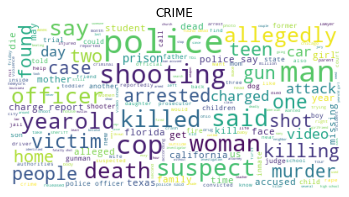

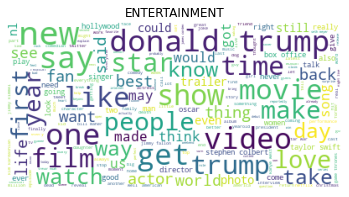

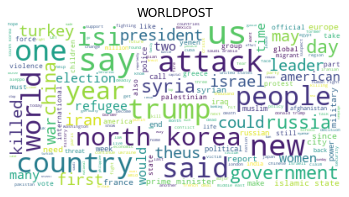

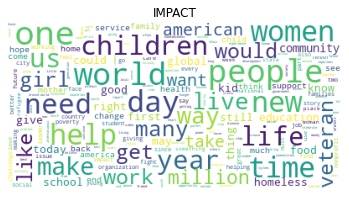

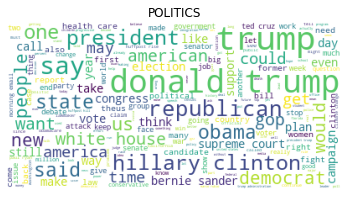

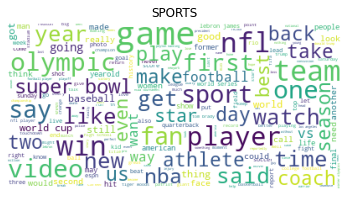

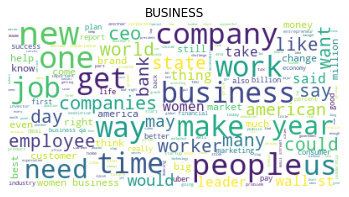

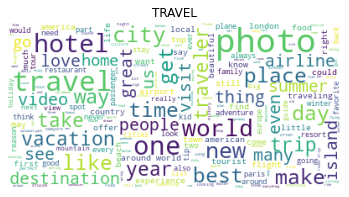

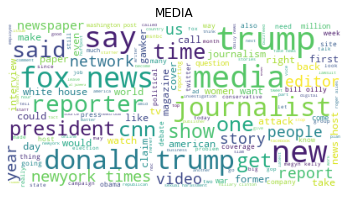

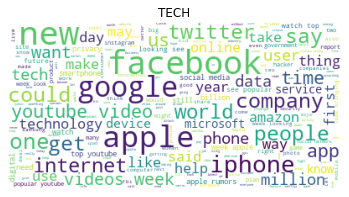

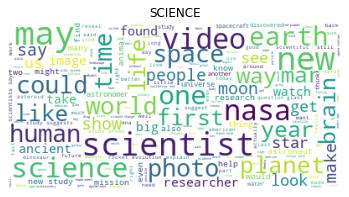

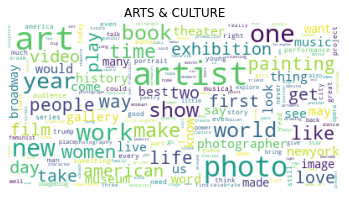

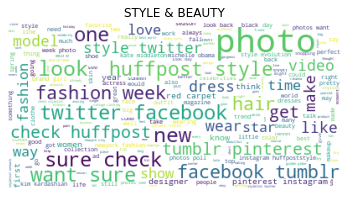

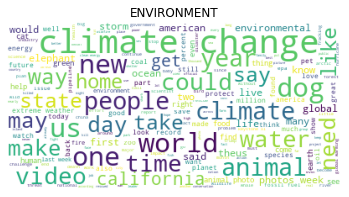

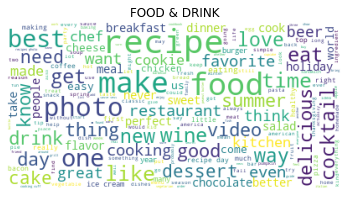

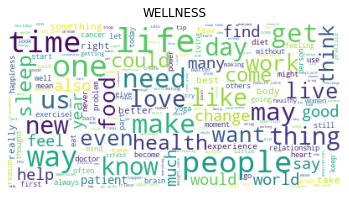

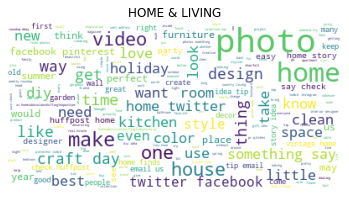

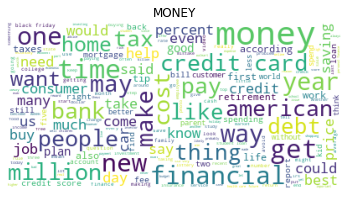

In [18]:
#stopwords = set(STOPWORDS)

# generuje wordcloud dla kazdej kategorii
for x in df.category.unique():
	wc = WordCloud(background_color="white", max_words=200, stopwords=list_stop_words,
                   max_font_size=40, random_state=42)
	wc.generate(df.text[(df.text.notnull()) & (df.category == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

# Stemming

In [21]:
from nltk.stem.porter import *

In [22]:
stemmer = PorterStemmer()

In [23]:
text_stemm= [[stemmer.stem(word) for word in text ] for text in text_nostop]


In [24]:
text_stemm[:2]

[['mass',
  'shoot',
  'texa',
  'last',
  'week',
  'tv',
  'left',
  'husband',
  'kill',
  'children',
  'anoth',
  'day',
  'america'],
 ['smith',
  'join',
  'diplo',
  'nicki',
  'jam',
  'world',
  'cup',
  'offici',
  'song',
  'cours',
  'song']]

In [25]:
text_stemm_joint=[' '.join(line) for line in text_stemm ]
df['stem']= pd.DataFrame(text_stemm_joint)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155510 entries, 0 to 155509
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           155510 non-null  object
 1   headline           155510 non-null  object
 2   short_description  155510 non-null  object
 3   text               155510 non-null  object
 4   stem               155510 non-null  object
dtypes: object(5)
memory usage: 5.9+ MB


# Lemmatization

In [28]:
lemmatizer = WordNetLemmatizer()

In [29]:
text_lemma=[[lemmatizer.lemmatize(word) for word in text] for text in text_nostop]

In [30]:
text_lemma[:2]

[['mass',
  'shooting',
  'texas',
  'last',
  'week',
  'tv',
  'left',
  'husband',
  'killed',
  'child',
  'another',
  'day',
  'america'],
 ['smith',
  'join',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song',
  'course',
  'song']]

In [31]:
text_lemma_joint=[' '.join(line) for line in text_lemma]
df['lemma']=pd.DataFrame(text_lemma_joint)

In [32]:
df.drop(columns=['headline','short_description'], inplace=True)

In [33]:
#dzielę zbiór danych na dane treningowe i testowe
train,test= train_test_split(df, test_size = 0.3, stratify=df['category'])

In [34]:
train_data= pd.DataFrame(train)
test_data= pd.DataFrame(test)

In [35]:
train_data.head()

category  ...                                                                                                                              lemma
32114   ENTERTAINMENT  ...                              lamar odom document road recovery new reality series former nba star entered rehab sometime last week
148300  ENTERTAINMENT  ...               best late night clip week videophotos week began ultimate collision comedy politics white house correspondent dinner
8679    ENTERTAINMENT  ...                                                                      stranger thing renewed season netflix bust celebratory waffle
27522        POLITICS  ...                                       latino democrat excluded meeting ice requested member wanted learn recent deportation effort
121690       WELLNESS  ...  hn bird flu case declining health official say cdc process developing hn flu vaccine case needed typically take six month produce

[5 rows x 4 columns]

# Vectorization

In [36]:
bow =CountVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

In [37]:
#wektoryzyje slowa po stemmingu
X_train_stem = bow.fit_transform(train_data['stem'])
X_test_stem = bow.transform(test_data['stem'])

#wektoryzuje slowa po lemmatyzacji
X_train_lemma = bow.fit_transform(train_data['lemma'])
X_test_lemma = bow.transform(test_data['lemma'])

# Vectorization TF-IDF

In [38]:
tfidf=TfidfVectorizer(min_df=5, max_df=0.3,ngram_range=(1,2), sublinear_tf=True)

In [39]:
#Wektoryzuje slowa po stemmingu
X_train_tfidf_stem = tfidf.fit_transform(train_data['stem'])
X_test_tfidf_stem = tfidf.transform(test_data['stem'])

#wektoryzuje slowa po lemmatyzacji
X_train_tfidf_lemma = tfidf.fit_transform(train_data['lemma'])
X_test_tfidf_lemma = tfidf.transform(test_data['lemma'])

In [40]:
y_train = train_data.category
y_test= test_data.category

# Classification models

In [41]:
from sklearn.svm import LinearSVC
nb_model=MultinomialNB()
lr= LogisticRegression()
sgdc_model= SGDClassifier()
svm= LinearSVC()
rfc=RandomForestClassifier()

# Naive Bayes

In [42]:
#nb_model= MultinomialNB()

## Bag of words ngram (1,2) stemmed data 

In [43]:
nb_model.fit(X_train_stem,y_train)

MultinomialNB()

In [44]:
y_pred_train=nb_model.predict(X_train_stem)
y_pred_test=nb_model.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

nb_bow_stem_train_acc = accuracy_score(y_train, y_pred_train)
nb_bow_stem_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8097963383154047
ACC test set: 0.732750305446595
                precision    recall  f1-score   support

ARTS & CULTURE       0.71      0.39      0.50      1163
      BUSINESS       0.51      0.50      0.50      1781
         CRIME       0.65      0.68      0.66      1022
 ENTERTAINMENT       0.74      0.78      0.76      6370
   ENVIRONMENT       0.60      0.50      0.55      1183
  FOOD & DRINK       0.77      0.82      0.79      2497
 HOME & LIVING       0.84      0.69      0.76      1258
        IMPACT       0.50      0.30      0.38      1038
         MEDIA       0.70      0.30      0.42       845
         MONEY       0.67      0.27      0.39       512
      POLITICS       0.79      0.83      0.81      9822
       SCIENCE       0.84      0.35      0.49       653
        SPORTS       0.81      0.69      0.74      1465
STYLE & BEAUTY       0.82      0.80      0.81      3571
          TECH       0.75      0.24      0.37       625
        TRAVEL       0.66      0.81  

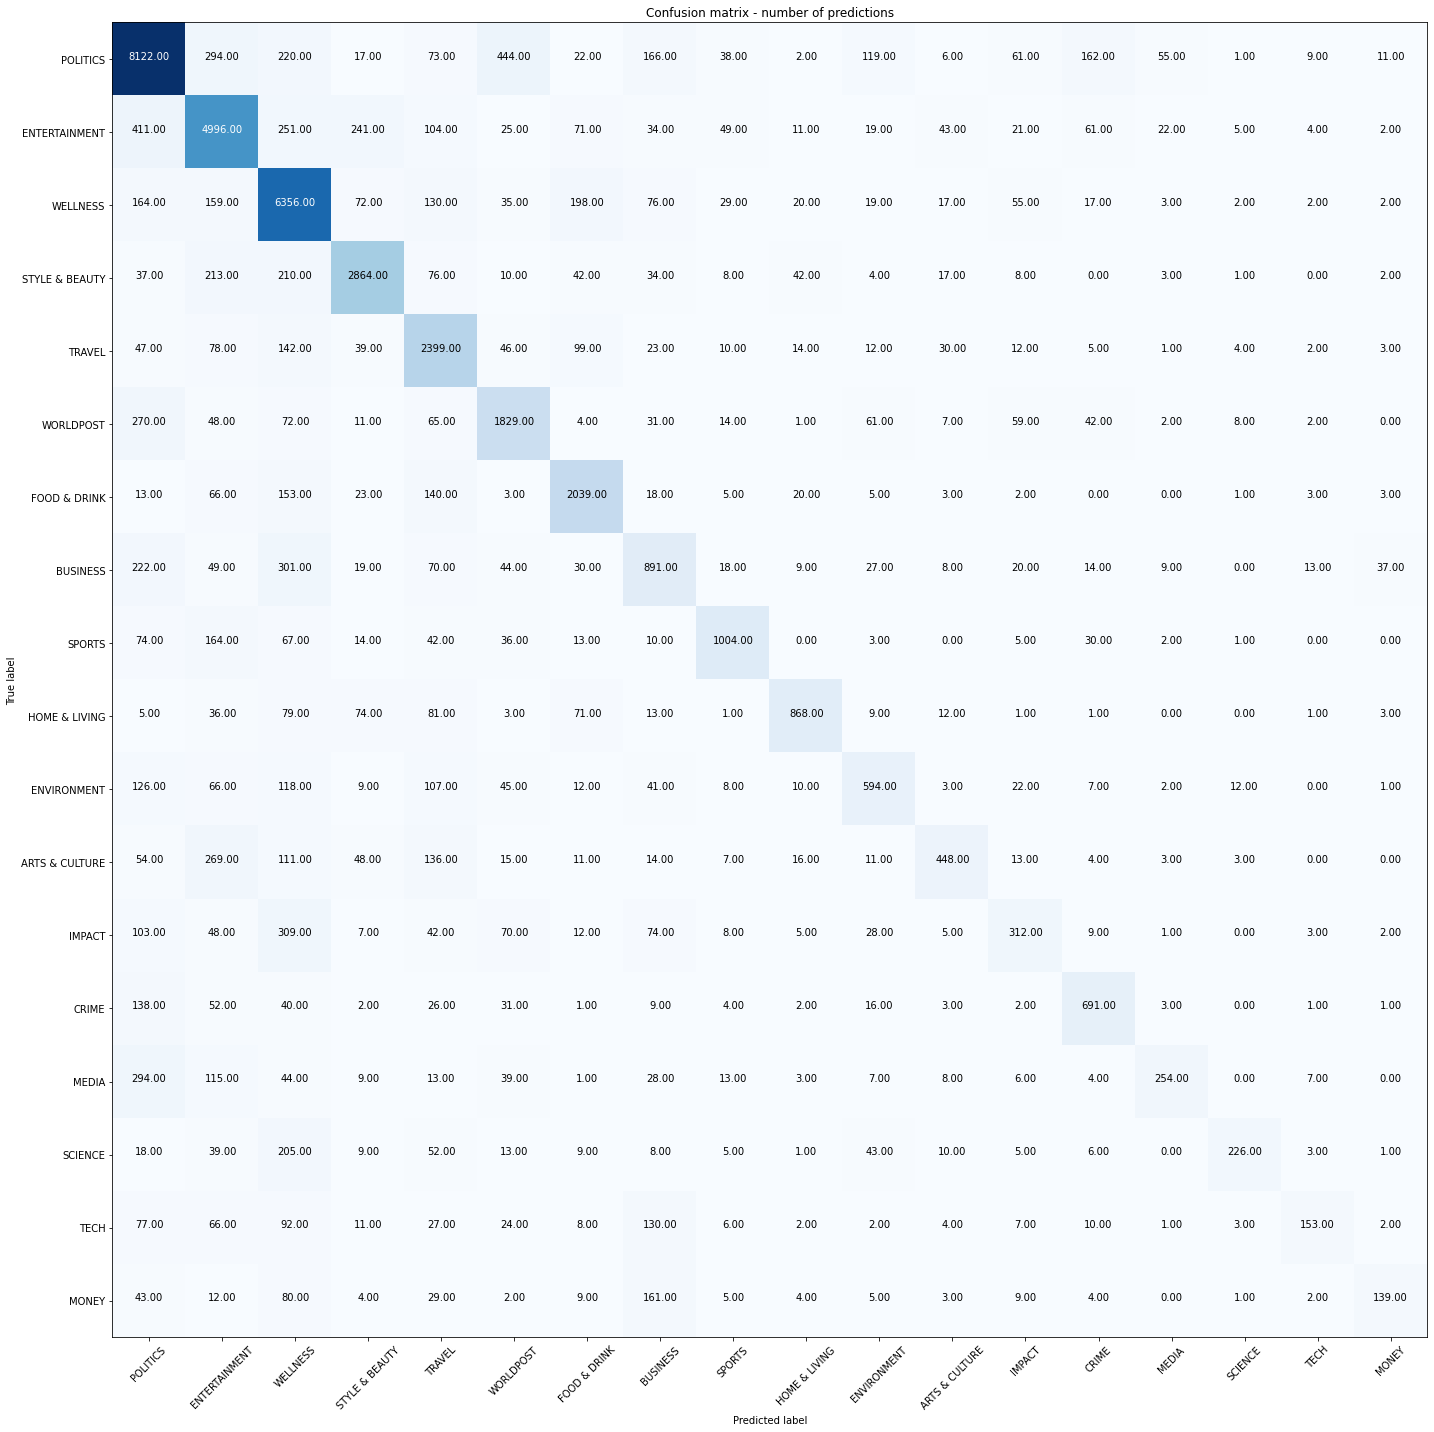

In [45]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram (1,2) lemmatized data 

In [46]:
nb_model.fit(X_train_lemma,y_train)

MultinomialNB()

In [47]:
y_pred_train=nb_model.predict(X_train_lemma)
y_pred_test=nb_model.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

nb_lemma_train_accuracy = accuracy_score(y_train, y_pred_train)
nb_lemma_test_accuracy = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8155010702113782
ACC test set: 0.7347651812316464
                precision    recall  f1-score   support

ARTS & CULTURE       0.69      0.41      0.51      1163
      BUSINESS       0.51      0.50      0.50      1781
         CRIME       0.65      0.69      0.67      1022
 ENTERTAINMENT       0.74      0.78      0.76      6370
   ENVIRONMENT       0.60      0.52      0.56      1183
  FOOD & DRINK       0.77      0.82      0.79      2497
 HOME & LIVING       0.84      0.70      0.76      1258
        IMPACT       0.49      0.30      0.37      1038
         MEDIA       0.71      0.34      0.46       845
         MONEY       0.64      0.28      0.39       512
      POLITICS       0.80      0.82      0.81      9822
       SCIENCE       0.81      0.36      0.50       653
        SPORTS       0.81      0.68      0.74      1465
STYLE & BEAUTY       0.83      0.80      0.81      3571
          TECH       0.71      0.26      0.38       625
        TRAVEL       0.67      0.81 

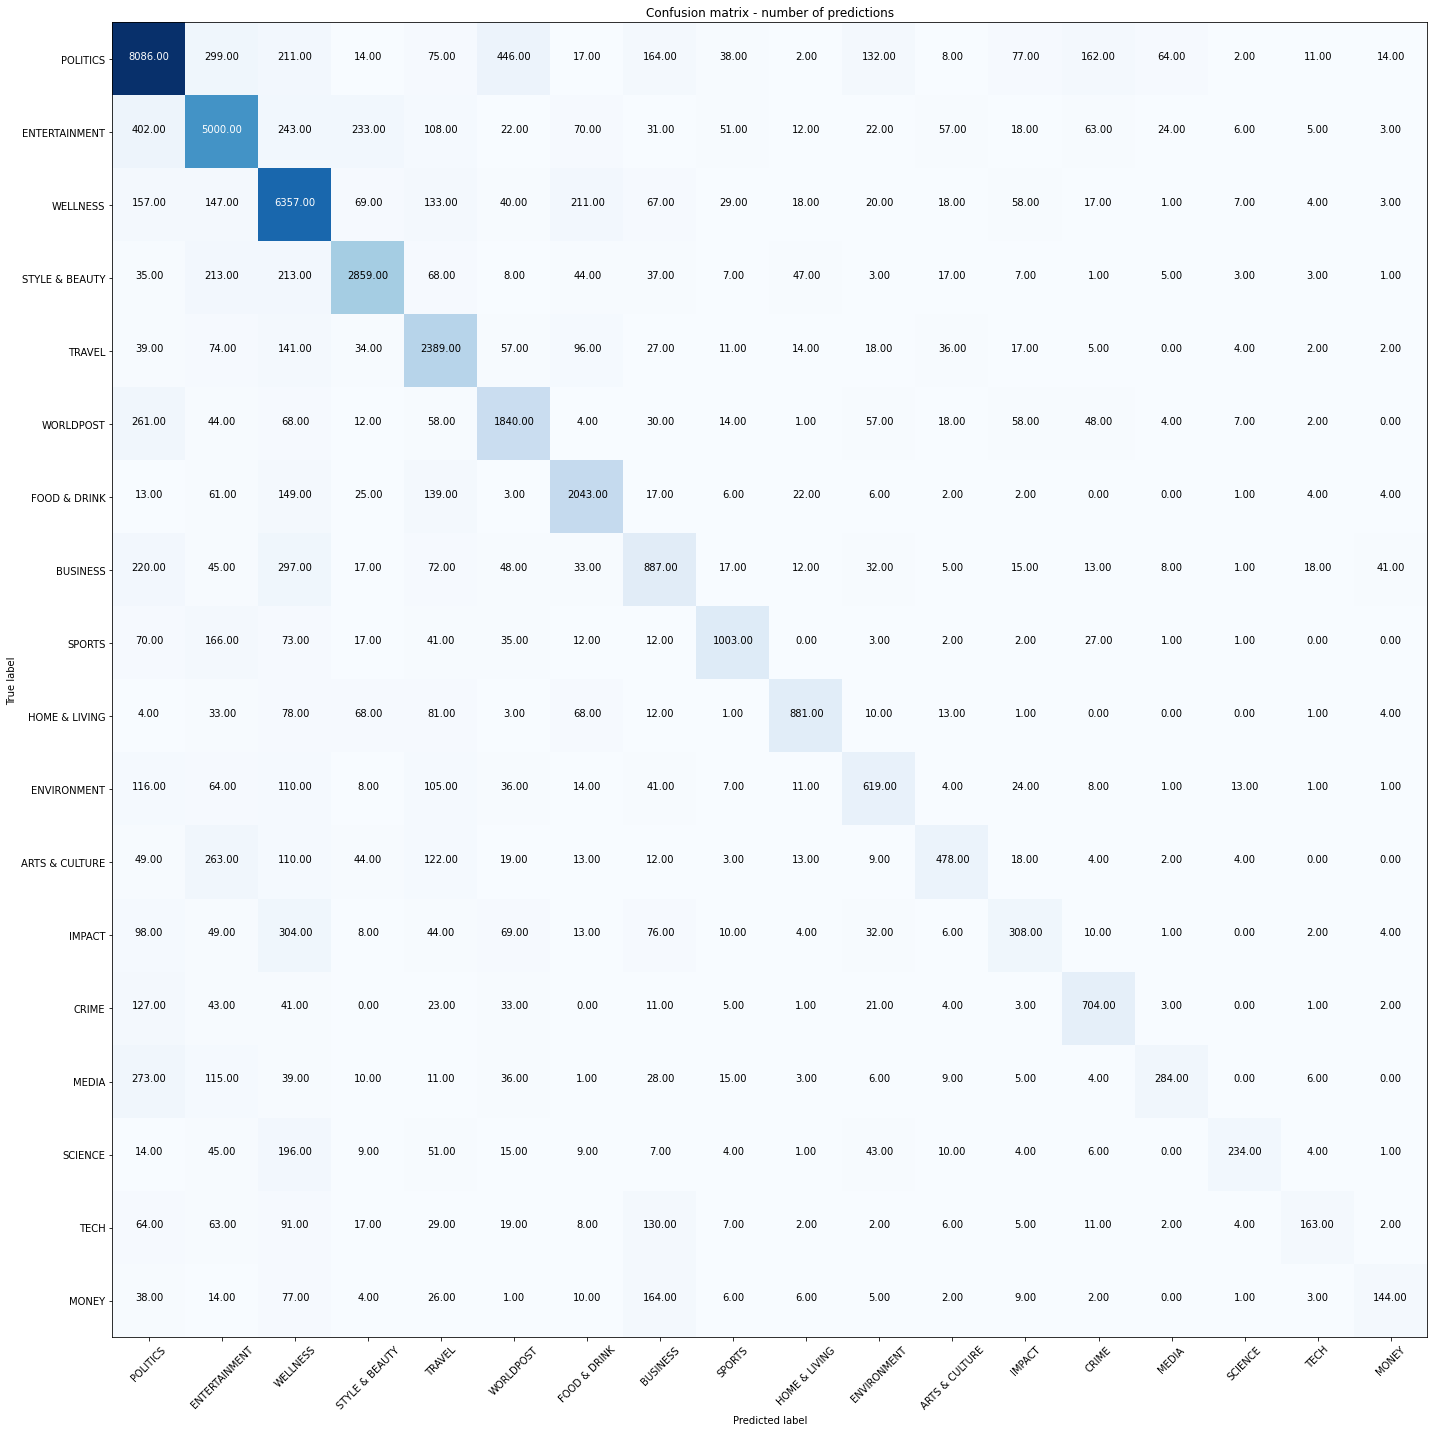

In [48]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF stemmed data

In [49]:
nb_model.fit(X_train_tfidf_stem,y_train)

MultinomialNB()

In [50]:
y_pred_train=nb_model.predict(X_train_tfidf_stem)
y_pred_test=nb_model.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

nb_tfidf_stem_train = accuracy_score(y_train, y_pred_train)
nb_tfidf_stem_test = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.6700717455009784
ACC test set: 0.6261762373266456
                precision    recall  f1-score   support

ARTS & CULTURE       0.96      0.04      0.08      1163
      BUSINESS       0.70      0.07      0.13      1781
         CRIME       0.90      0.14      0.24      1022
 ENTERTAINMENT       0.63      0.80      0.71      6370
   ENVIRONMENT       0.89      0.07      0.12      1183
  FOOD & DRINK       0.86      0.60      0.71      2497
 HOME & LIVING       0.98      0.30      0.45      1258
        IMPACT       0.67      0.00      0.00      1038
         MEDIA       1.00      0.01      0.02       845
         MONEY       1.00      0.00      0.01       512
      POLITICS       0.57      0.95      0.71      9822
       SCIENCE       1.00      0.02      0.05       653
        SPORTS       0.91      0.24      0.39      1465
STYLE & BEAUTY       0.86      0.70      0.77      3571
          TECH       1.00      0.04      0.08       625
        TRAVEL       0.75      0.62 

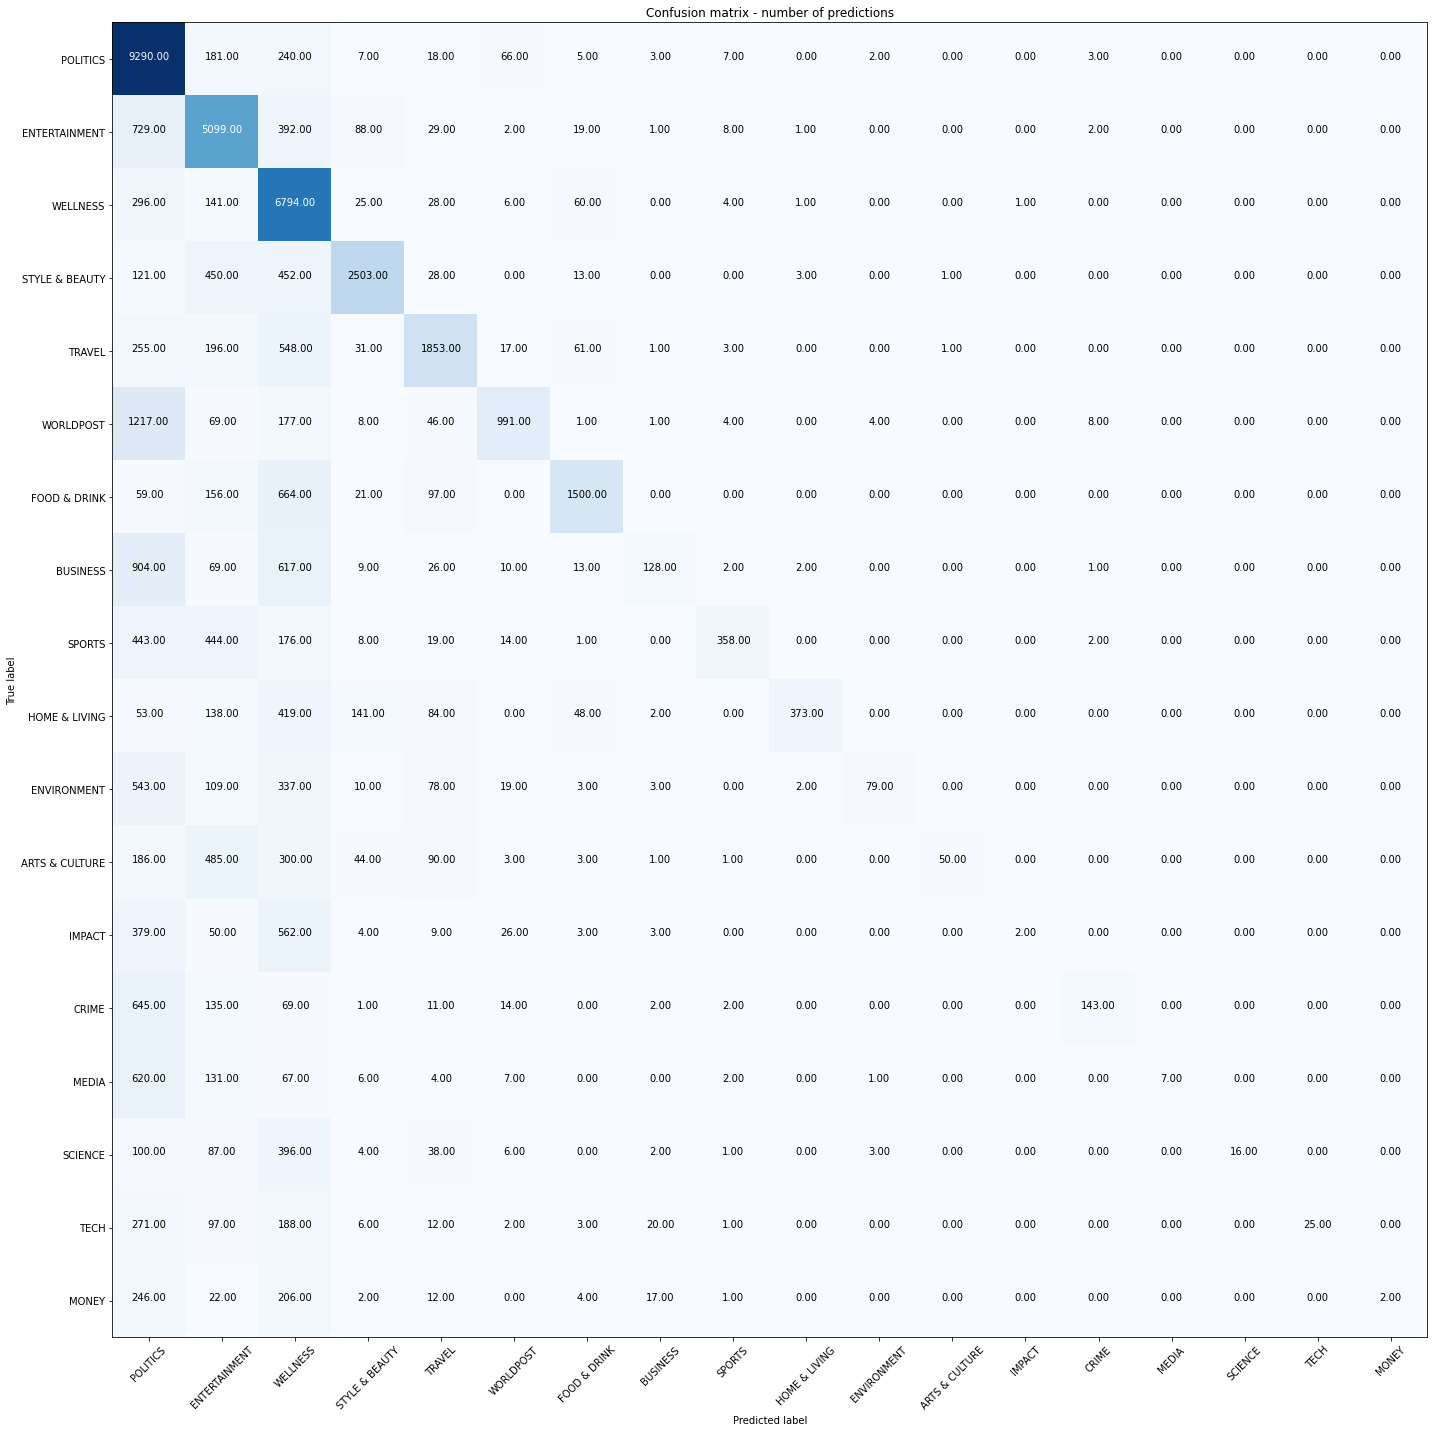

In [51]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF lemmatized data

In [52]:
nb_model.fit(X_train_tfidf_lemma,y_train)

MultinomialNB()

In [53]:
y_pred_train=nb_model.predict(X_train_tfidf_lemma)
y_pred_test=nb_model.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

nb_tfidf_lemma_train = accuracy_score(y_train, y_pred_train)
nb_tfidf_lemma_test = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.6785140137979184
ACC test set: 0.6317921677062568
                precision    recall  f1-score   support

ARTS & CULTURE       0.92      0.05      0.09      1163
      BUSINESS       0.68      0.08      0.14      1781
         CRIME       0.89      0.15      0.26      1022
 ENTERTAINMENT       0.64      0.81      0.71      6370
   ENVIRONMENT       0.88      0.08      0.14      1183
  FOOD & DRINK       0.86      0.61      0.72      2497
 HOME & LIVING       0.98      0.31      0.47      1258
        IMPACT       0.60      0.00      0.01      1038
         MEDIA       0.92      0.01      0.03       845
         MONEY       0.50      0.00      0.00       512
      POLITICS       0.57      0.94      0.71      9822
       SCIENCE       1.00      0.03      0.07       653
        SPORTS       0.92      0.27      0.42      1465
STYLE & BEAUTY       0.86      0.71      0.78      3571
          TECH       1.00      0.04      0.08       625
        TRAVEL       0.74      0.63 

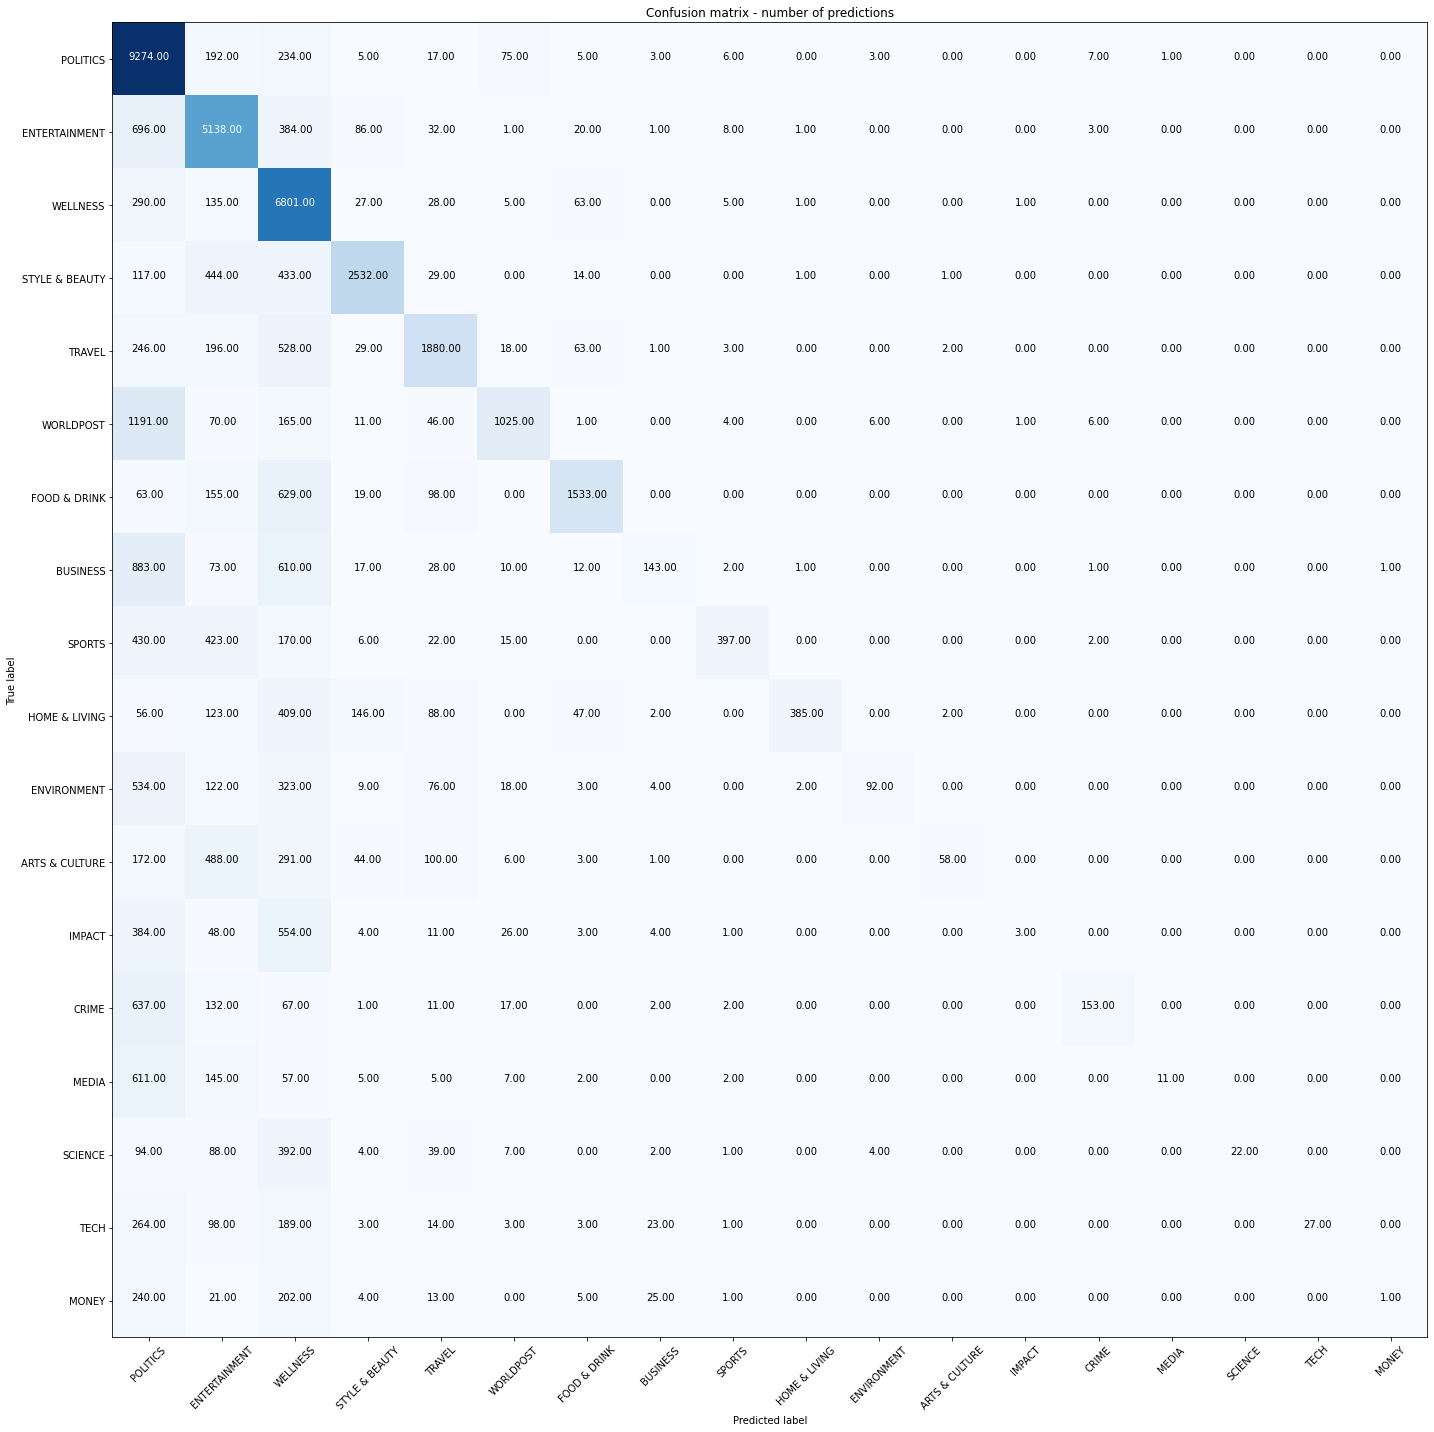

In [54]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Logistic Regression

In [55]:
lr= LogisticRegression()

## Bag of words ngram (1,2) stemmed data

In [56]:
lr.fit(X_train_stem,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [57]:
y_pred_train=lr.predict(X_train_stem)
y_pred_test=lr.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

log_reg_bow_stemm_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_bow_stemm_acc_test = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9704382814150675
ACC test set: 0.7358797933680578
                precision    recall  f1-score   support

ARTS & CULTURE       0.63      0.50      0.56      1163
      BUSINESS       0.53      0.47      0.50      1781
         CRIME       0.68      0.62      0.65      1022
 ENTERTAINMENT       0.72      0.80      0.76      6370
   ENVIRONMENT       0.57      0.50      0.53      1183
  FOOD & DRINK       0.80      0.78      0.79      2497
 HOME & LIVING       0.80      0.75      0.77      1258
        IMPACT       0.45      0.34      0.39      1038
         MEDIA       0.58      0.42      0.49       845
         MONEY       0.57      0.42      0.48       512
      POLITICS       0.78      0.84      0.81      9822
       SCIENCE       0.63      0.47      0.54       653
        SPORTS       0.79      0.72      0.75      1465
STYLE & BEAUTY       0.85      0.81      0.83      3571
          TECH       0.56      0.44      0.49       625
        TRAVEL       0.76      0.75 

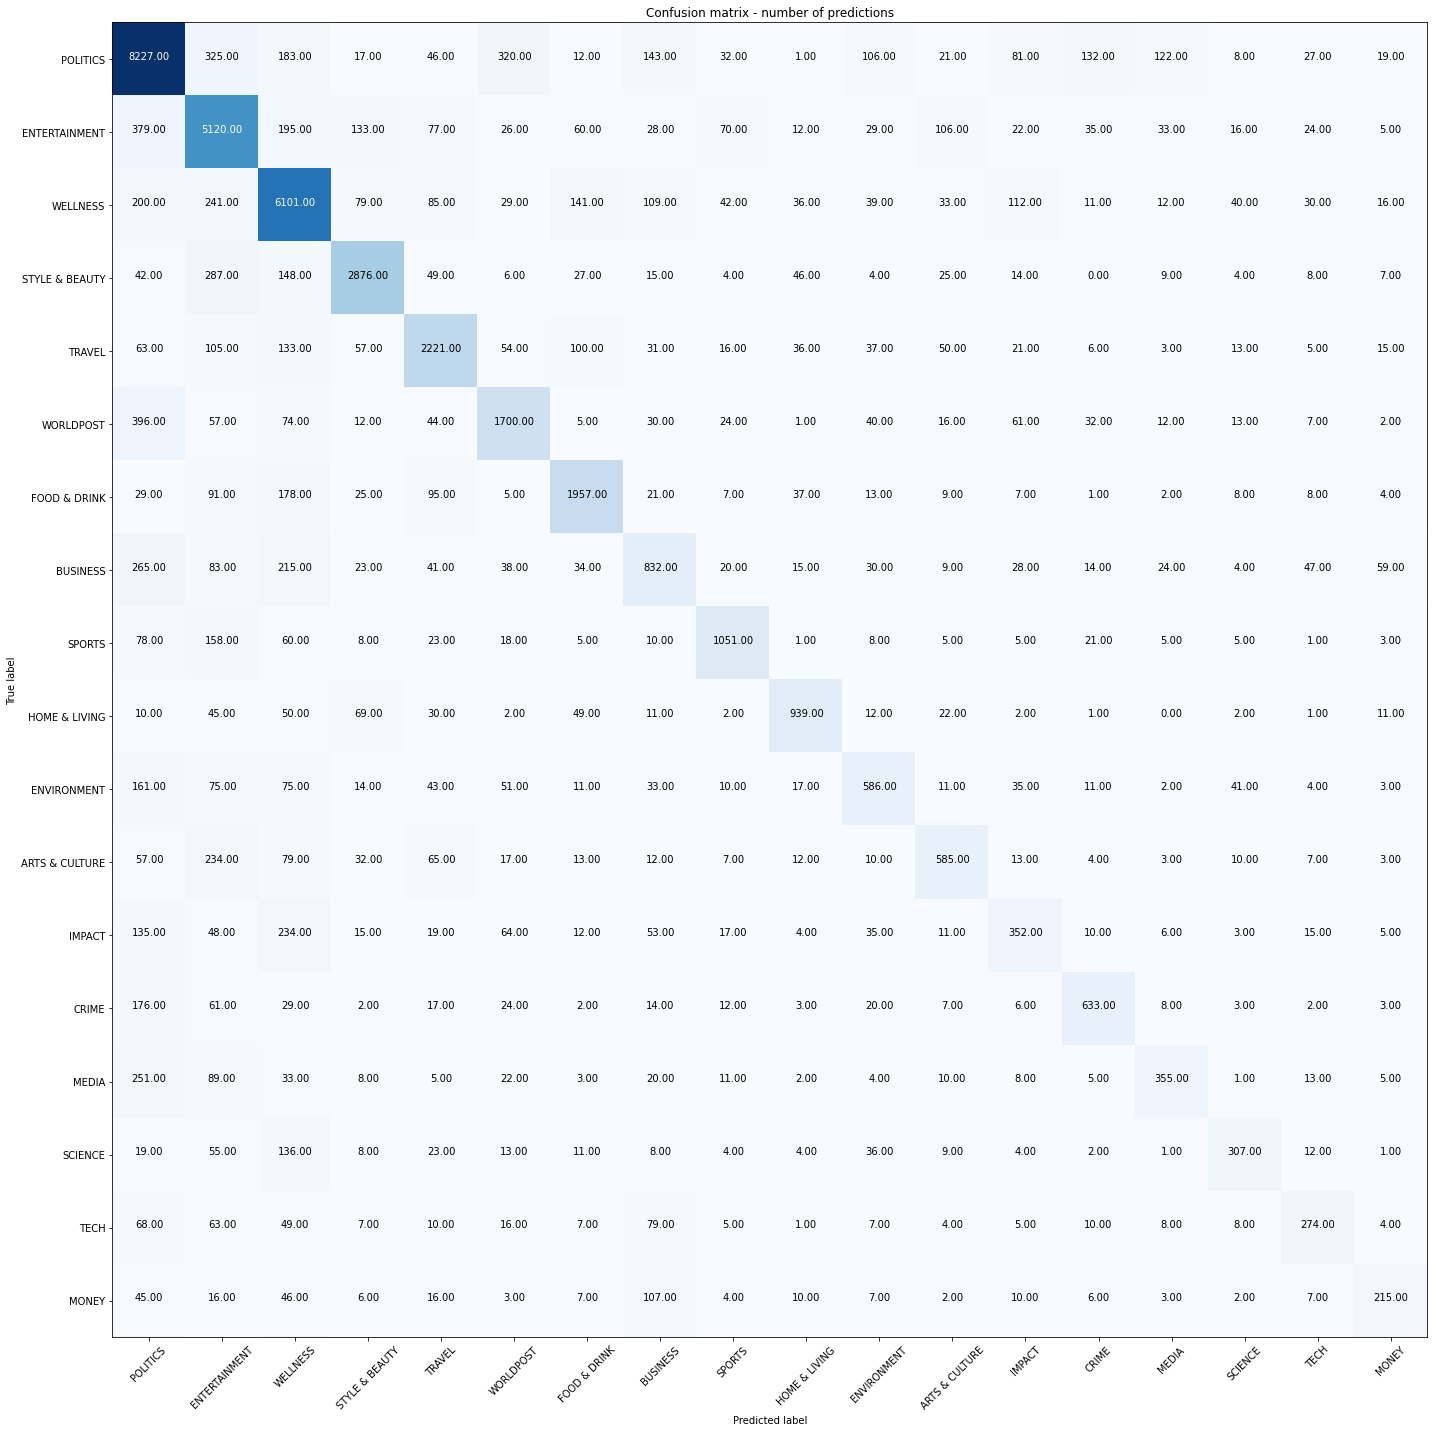

In [58]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram (1,2) lemmatized data

In [59]:
lr.fit(X_train_lemma,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [60]:
y_pred_train=lr.predict(X_train_lemma)
y_pred_test=lr.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

log_reg_bow_lemma_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_bow_lemma_acc_test = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9736443223678771
ACC test set: 0.7368443615630291
                precision    recall  f1-score   support

ARTS & CULTURE       0.61      0.49      0.55      1163
      BUSINESS       0.53      0.47      0.50      1781
         CRIME       0.67      0.62      0.65      1022
 ENTERTAINMENT       0.72      0.81      0.76      6370
   ENVIRONMENT       0.58      0.49      0.53      1183
  FOOD & DRINK       0.79      0.79      0.79      2497
 HOME & LIVING       0.81      0.74      0.78      1258
        IMPACT       0.45      0.32      0.37      1038
         MEDIA       0.60      0.43      0.50       845
         MONEY       0.58      0.41      0.48       512
      POLITICS       0.78      0.84      0.81      9822
       SCIENCE       0.62      0.48      0.54       653
        SPORTS       0.79      0.71      0.75      1465
STYLE & BEAUTY       0.84      0.81      0.82      3571
          TECH       0.57      0.42      0.48       625
        TRAVEL       0.77      0.75 

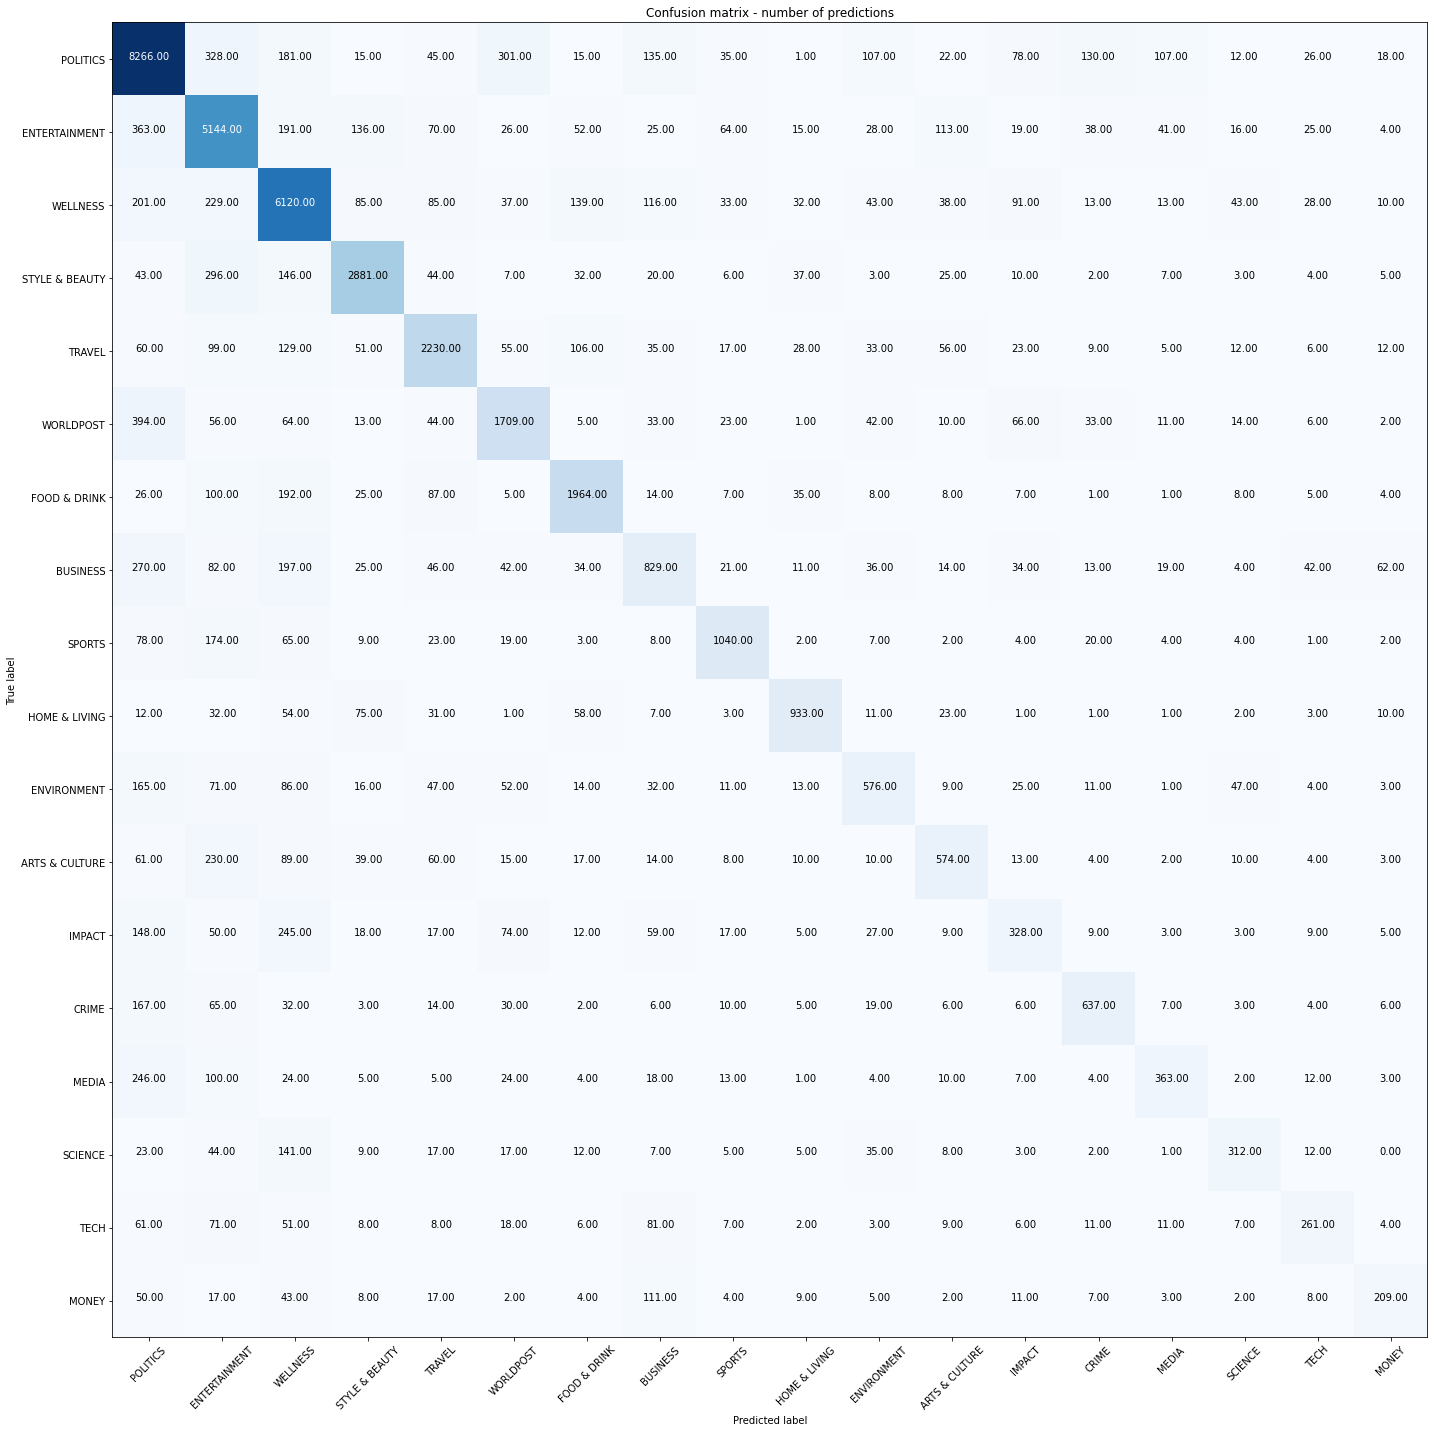

In [61]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Stemmed data

In [62]:
lr.fit(X_train_tfidf_stem,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [63]:
y_pred_train=lr.predict(X_train_tfidf_stem)
y_pred_test=lr.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

log_reg_tfidf_stemm_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_tfidf_stemm_acc_test = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8192674793536474
ACC test set: 0.7440036010545945
                precision    recall  f1-score   support

ARTS & CULTURE       0.70      0.46      0.55      1163
      BUSINESS       0.60      0.46      0.52      1781
         CRIME       0.74      0.58      0.65      1022
 ENTERTAINMENT       0.72      0.81      0.77      6370
   ENVIRONMENT       0.64      0.48      0.55      1183
  FOOD & DRINK       0.80      0.78      0.79      2497
 HOME & LIVING       0.82      0.72      0.77      1258
        IMPACT       0.55      0.30      0.39      1038
         MEDIA       0.69      0.37      0.48       845
         MONEY       0.64      0.35      0.45       512
      POLITICS       0.76      0.88      0.81      9822
       SCIENCE       0.77      0.39      0.52       653
        SPORTS       0.82      0.69      0.75      1465
STYLE & BEAUTY       0.84      0.81      0.83      3571
          TECH       0.62      0.36      0.45       625
        TRAVEL       0.76      0.77 

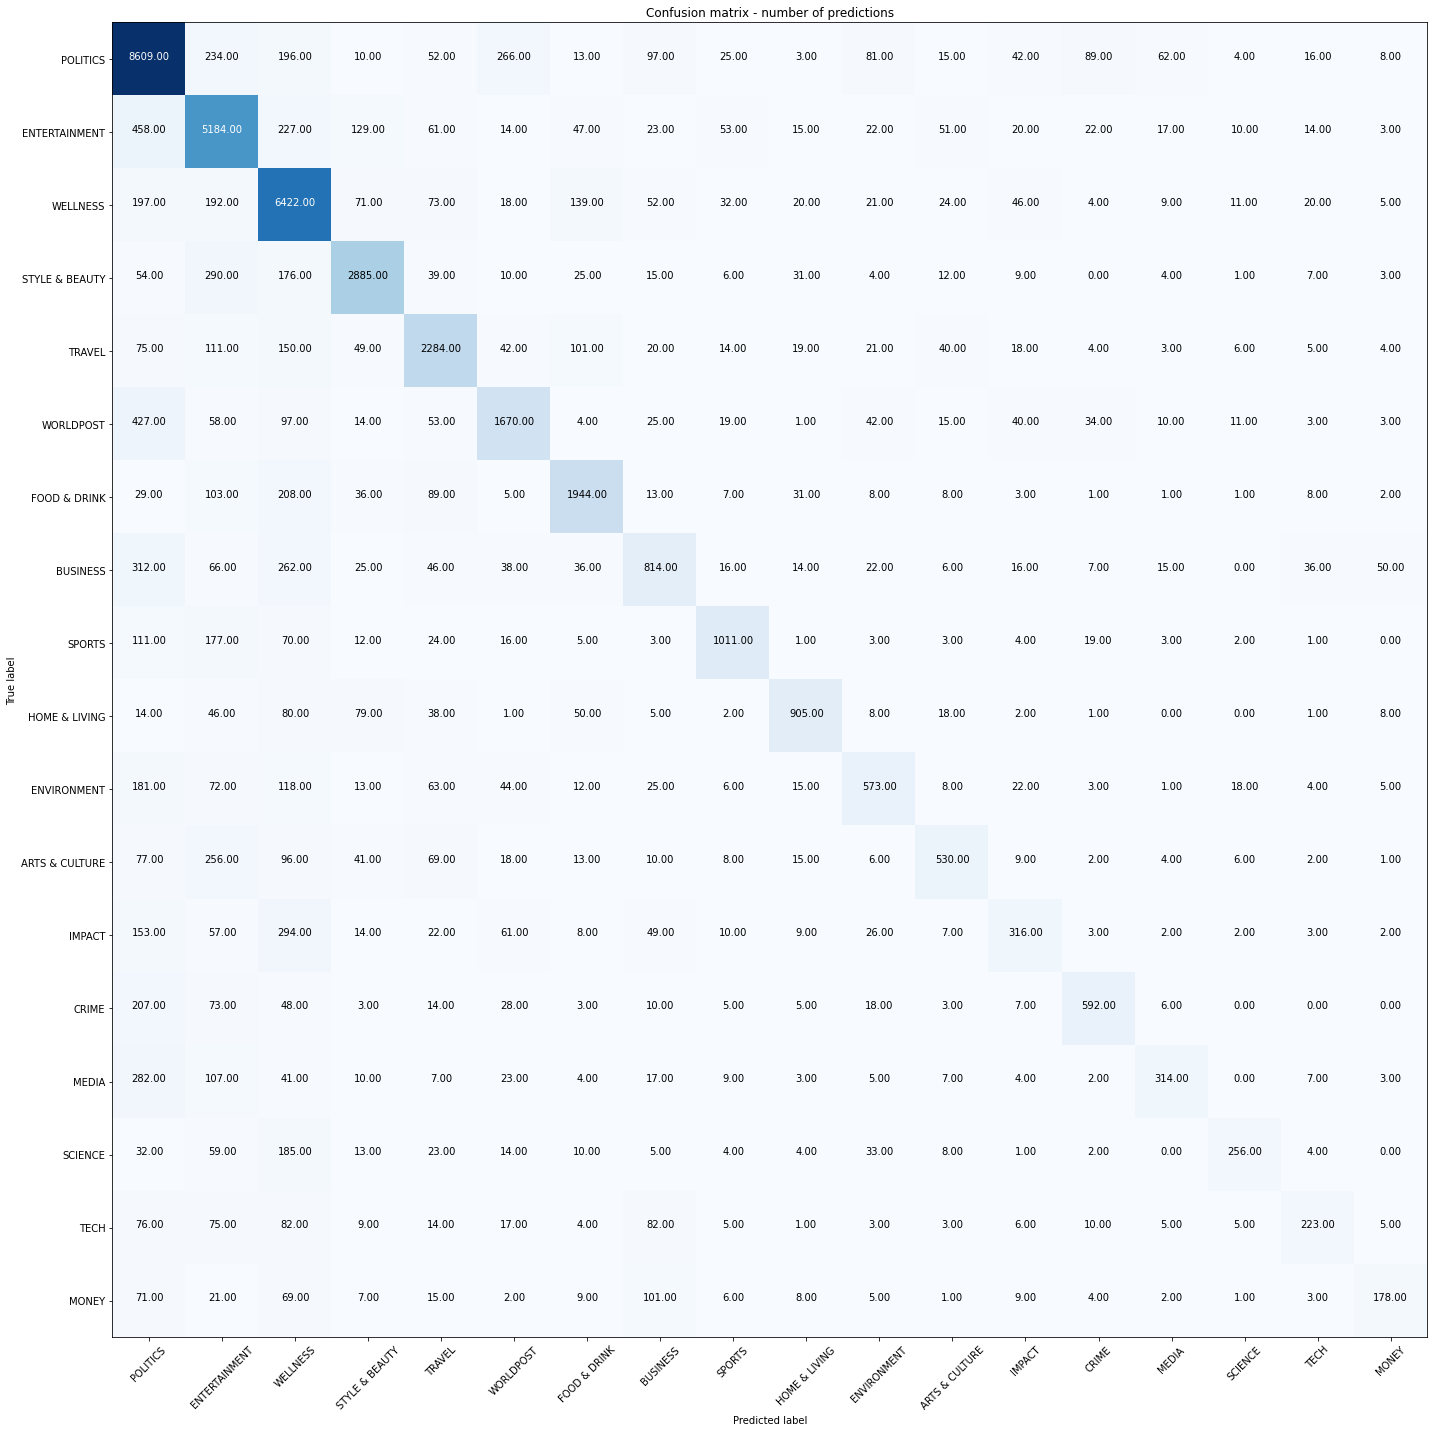

In [64]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Lemmatized data

In [65]:
lr.fit(X_train_tfidf_lemma,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [66]:
y_pred_train=lr.predict(X_train_tfidf_lemma)
y_pred_test=lr.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

log_reg_tfidf_lemma_acc_train = accuracy_score(y_train, y_pred_train)
log_reg_tfidf_lemma_acc_test = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8169617020494777
ACC test set: 0.7427818146742975
                precision    recall  f1-score   support

ARTS & CULTURE       0.70      0.46      0.55      1163
      BUSINESS       0.58      0.44      0.50      1781
         CRIME       0.72      0.59      0.65      1022
 ENTERTAINMENT       0.73      0.81      0.77      6370
   ENVIRONMENT       0.63      0.47      0.54      1183
  FOOD & DRINK       0.81      0.78      0.79      2497
 HOME & LIVING       0.85      0.70      0.76      1258
        IMPACT       0.56      0.28      0.37      1038
         MEDIA       0.70      0.36      0.48       845
         MONEY       0.67      0.32      0.44       512
      POLITICS       0.76      0.87      0.81      9822
       SCIENCE       0.76      0.40      0.52       653
        SPORTS       0.82      0.69      0.75      1465
STYLE & BEAUTY       0.84      0.81      0.82      3571
          TECH       0.64      0.34      0.44       625
        TRAVEL       0.76      0.77 

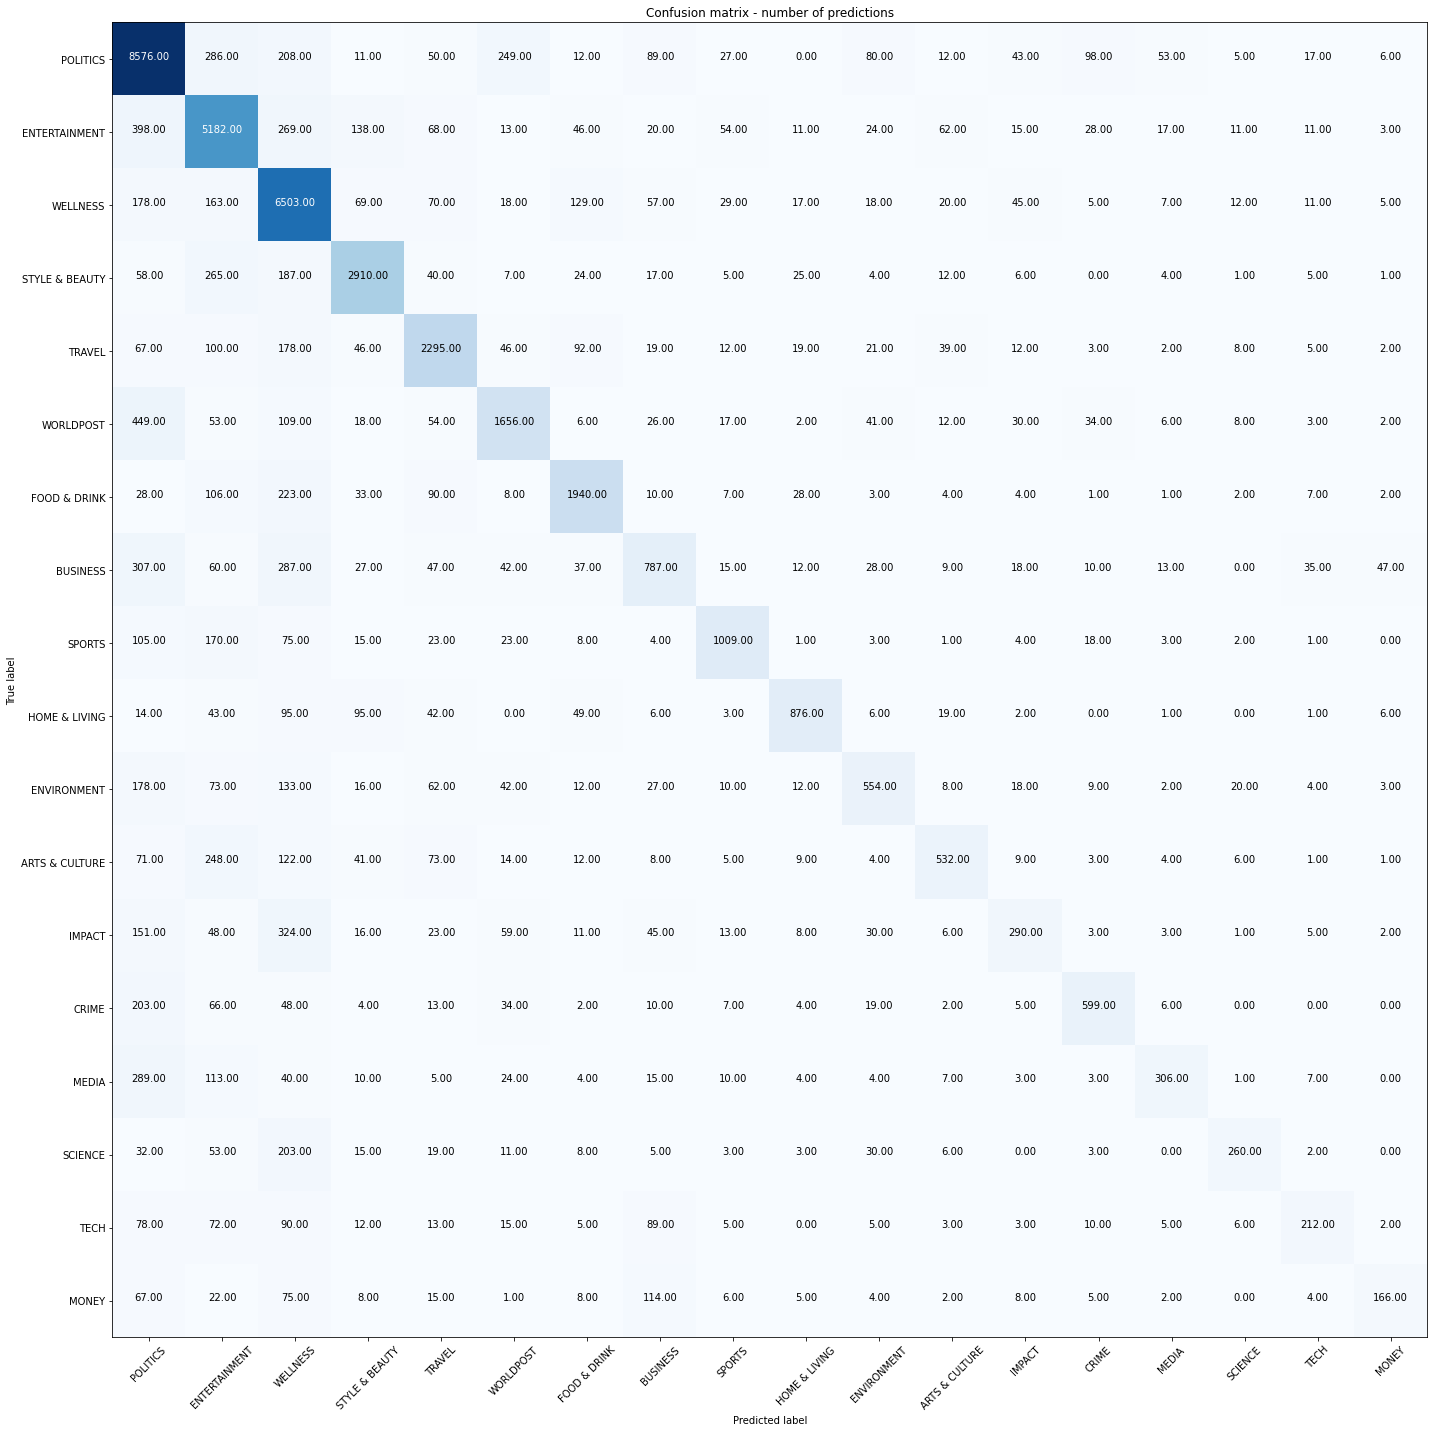

In [67]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Random Forest

## On stemmed data

In [68]:
rfc.fit(X_train_stem,y_train)

RandomForestClassifier()

In [69]:
y_pred_train=rfc.predict(X_train_stem)
y_pred_test=rfc.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

rfc_stem_acc_train = accuracy_score(y_train, y_pred_train)
rfc_stem_acc_test =  accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9998438318160523
ACC test set: 0.6634300045013183
                precision    recall  f1-score   support

ARTS & CULTURE       0.64      0.33      0.43      1163
      BUSINESS       0.51      0.33      0.40      1781
         CRIME       0.64      0.53      0.58      1022
 ENTERTAINMENT       0.62      0.74      0.67      6370
   ENVIRONMENT       0.56      0.22      0.32      1183
  FOOD & DRINK       0.73      0.74      0.74      2497
 HOME & LIVING       0.80      0.58      0.67      1258
        IMPACT       0.64      0.08      0.14      1038
         MEDIA       0.60      0.22      0.32       845
         MONEY       0.72      0.07      0.13       512
      POLITICS       0.70      0.87      0.77      9822
       SCIENCE       0.62      0.25      0.35       653
        SPORTS       0.72      0.52      0.61      1465
STYLE & BEAUTY       0.77      0.75      0.76      3571
          TECH       0.69      0.20      0.31       625
        TRAVEL       0.71      0.62 

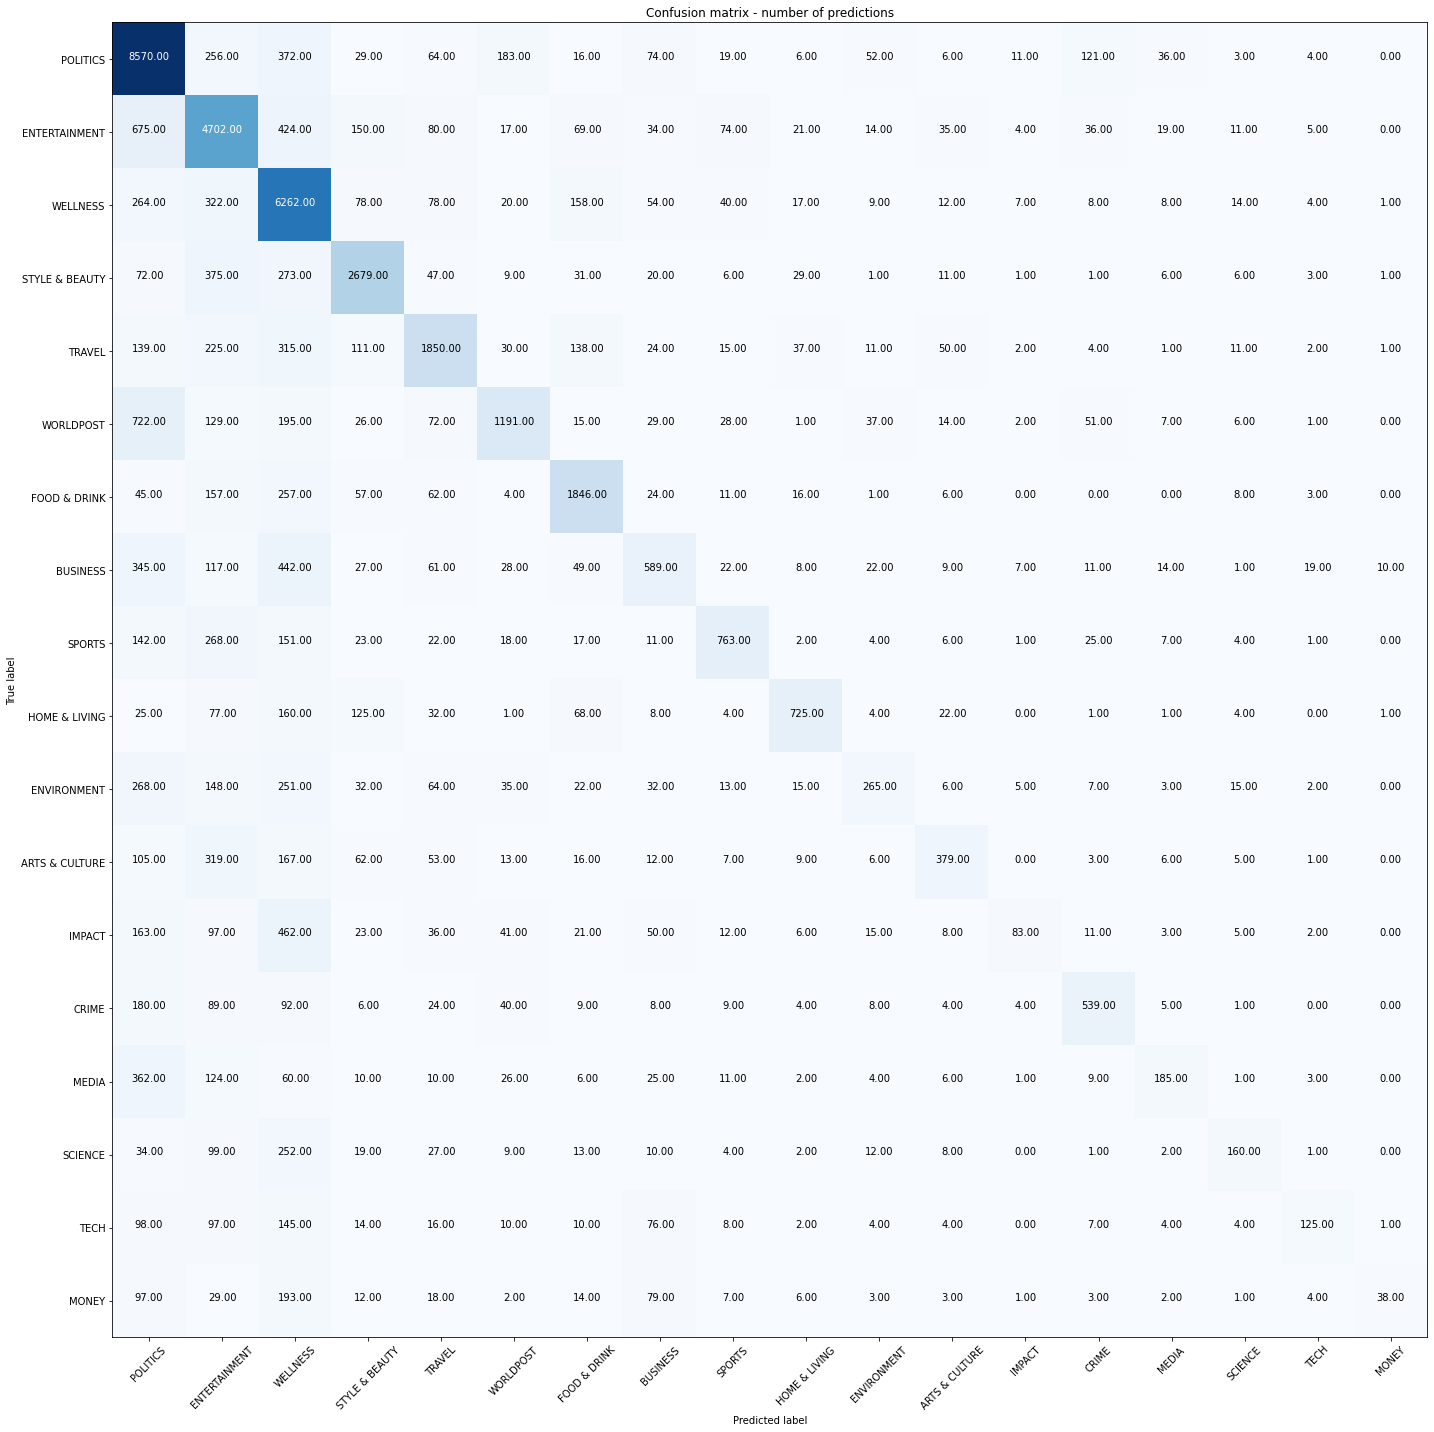

In [70]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## On lemmatized data

In [71]:
rfc.fit(X_train_lemma,y_train)

RandomForestClassifier()

In [72]:
y_pred_train=rfc.predict(X_train_lemma)
y_pred_test=rfc.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

rfc_lemma_acc_train = accuracy_score(y_train, y_pred_train)
rfc_lemma_acc_test =  accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9998346454522906
ACC test set: 0.6637515272329754
                precision    recall  f1-score   support

ARTS & CULTURE       0.64      0.35      0.45      1163
      BUSINESS       0.50      0.34      0.40      1781
         CRIME       0.62      0.53      0.57      1022
 ENTERTAINMENT       0.61      0.74      0.67      6370
   ENVIRONMENT       0.55      0.25      0.35      1183
  FOOD & DRINK       0.72      0.75      0.73      2497
 HOME & LIVING       0.80      0.56      0.66      1258
        IMPACT       0.54      0.06      0.11      1038
         MEDIA       0.63      0.23      0.34       845
         MONEY       0.83      0.08      0.15       512
      POLITICS       0.70      0.87      0.78      9822
       SCIENCE       0.62      0.26      0.36       653
        SPORTS       0.72      0.53      0.61      1465
STYLE & BEAUTY       0.78      0.75      0.77      3571
          TECH       0.67      0.19      0.30       625
        TRAVEL       0.70      0.62 

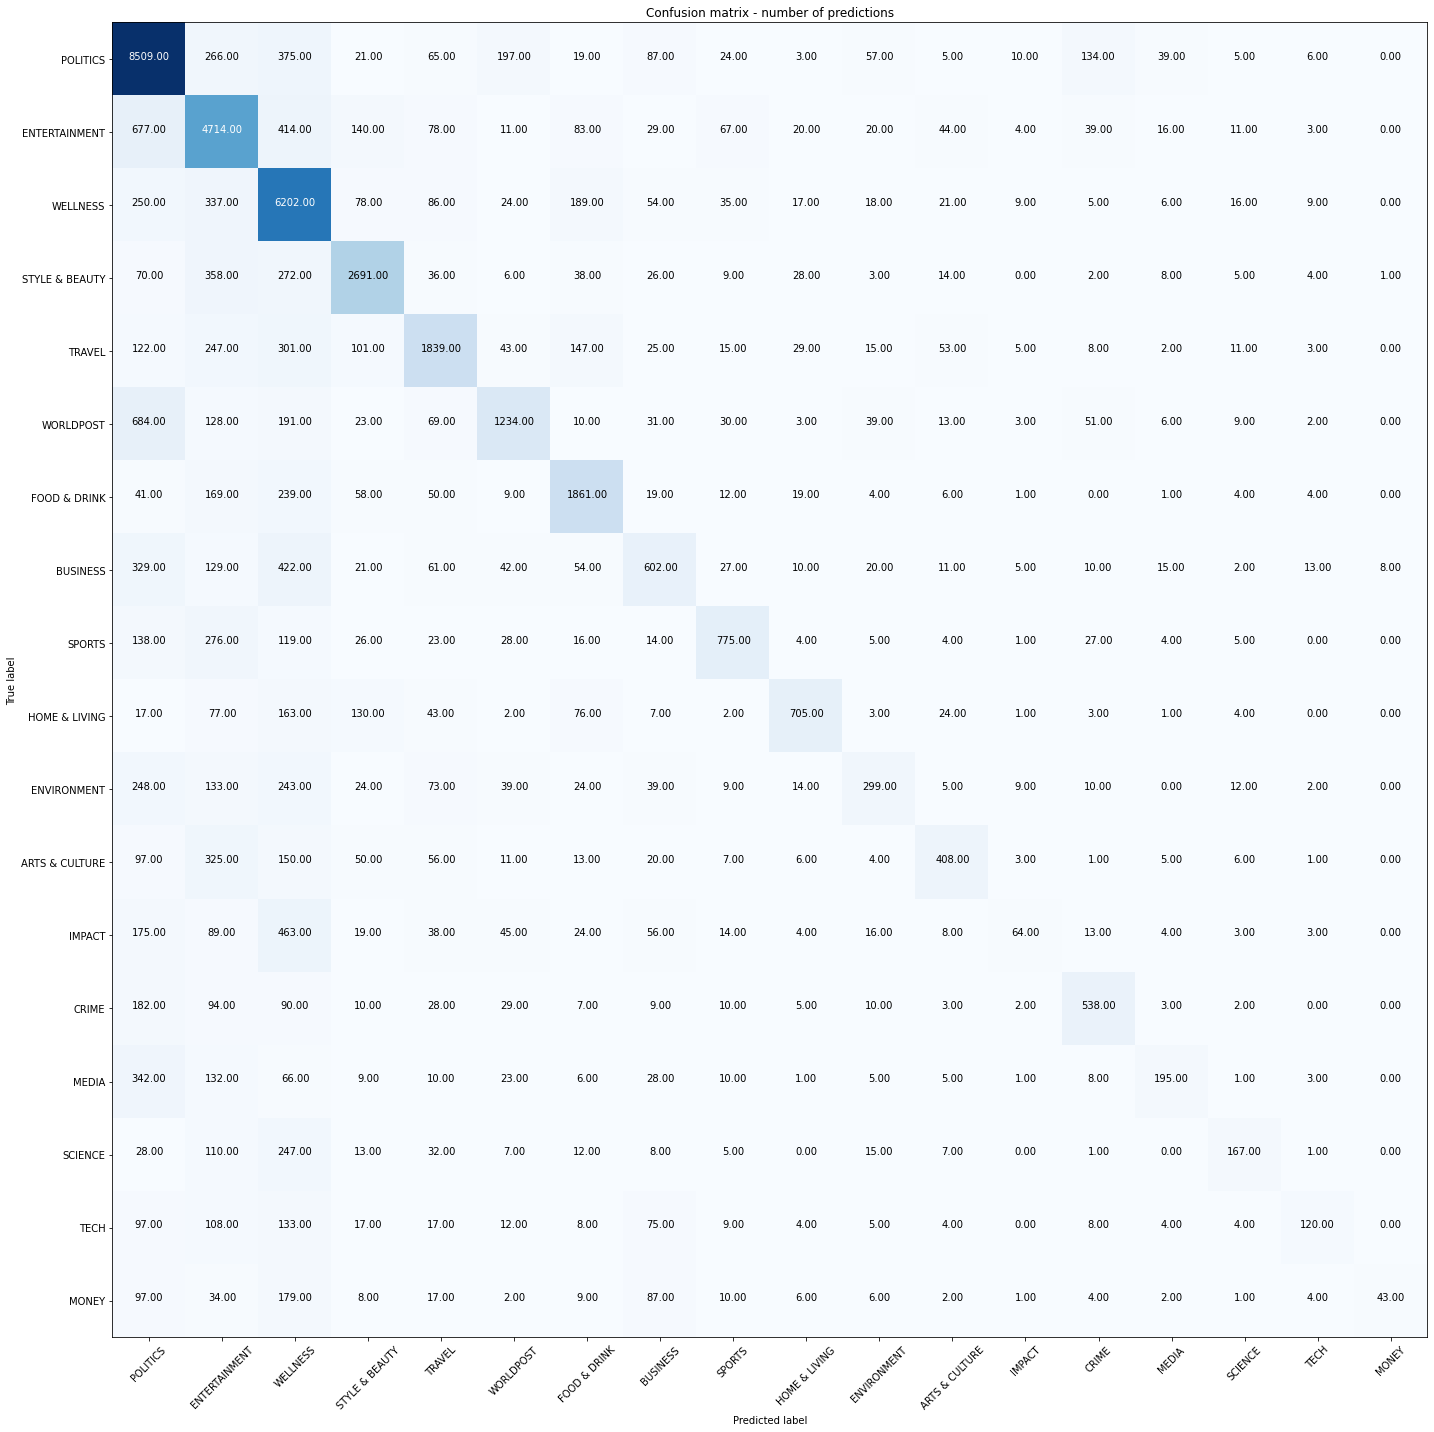

In [73]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [74]:
rfc.fit(X_train_tfidf_stem,y_train)

RandomForestClassifier()

In [75]:
y_pred_train=rfc.predict(X_train_tfidf_stem)
y_pred_test=rfc.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

rfc_tfidf_stem_acc_train = accuracy_score(y_train, y_pred_train)
rfc_tfidf_stem_acc_test =  accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9998438318160523
ACC test set: 0.6618438256918098
                precision    recall  f1-score   support

ARTS & CULTURE       0.66      0.33      0.44      1163
      BUSINESS       0.55      0.30      0.39      1781
         CRIME       0.66      0.51      0.58      1022
 ENTERTAINMENT       0.61      0.74      0.67      6370
   ENVIRONMENT       0.58      0.22      0.32      1183
  FOOD & DRINK       0.73      0.74      0.74      2497
 HOME & LIVING       0.77      0.58      0.66      1258
        IMPACT       0.73      0.07      0.13      1038
         MEDIA       0.64      0.21      0.31       845
         MONEY       0.77      0.08      0.14       512
      POLITICS       0.69      0.87      0.77      9822
       SCIENCE       0.74      0.21      0.33       653
        SPORTS       0.73      0.51      0.60      1465
STYLE & BEAUTY       0.76      0.76      0.76      3571
          TECH       0.71      0.24      0.35       625
        TRAVEL       0.70      0.62 

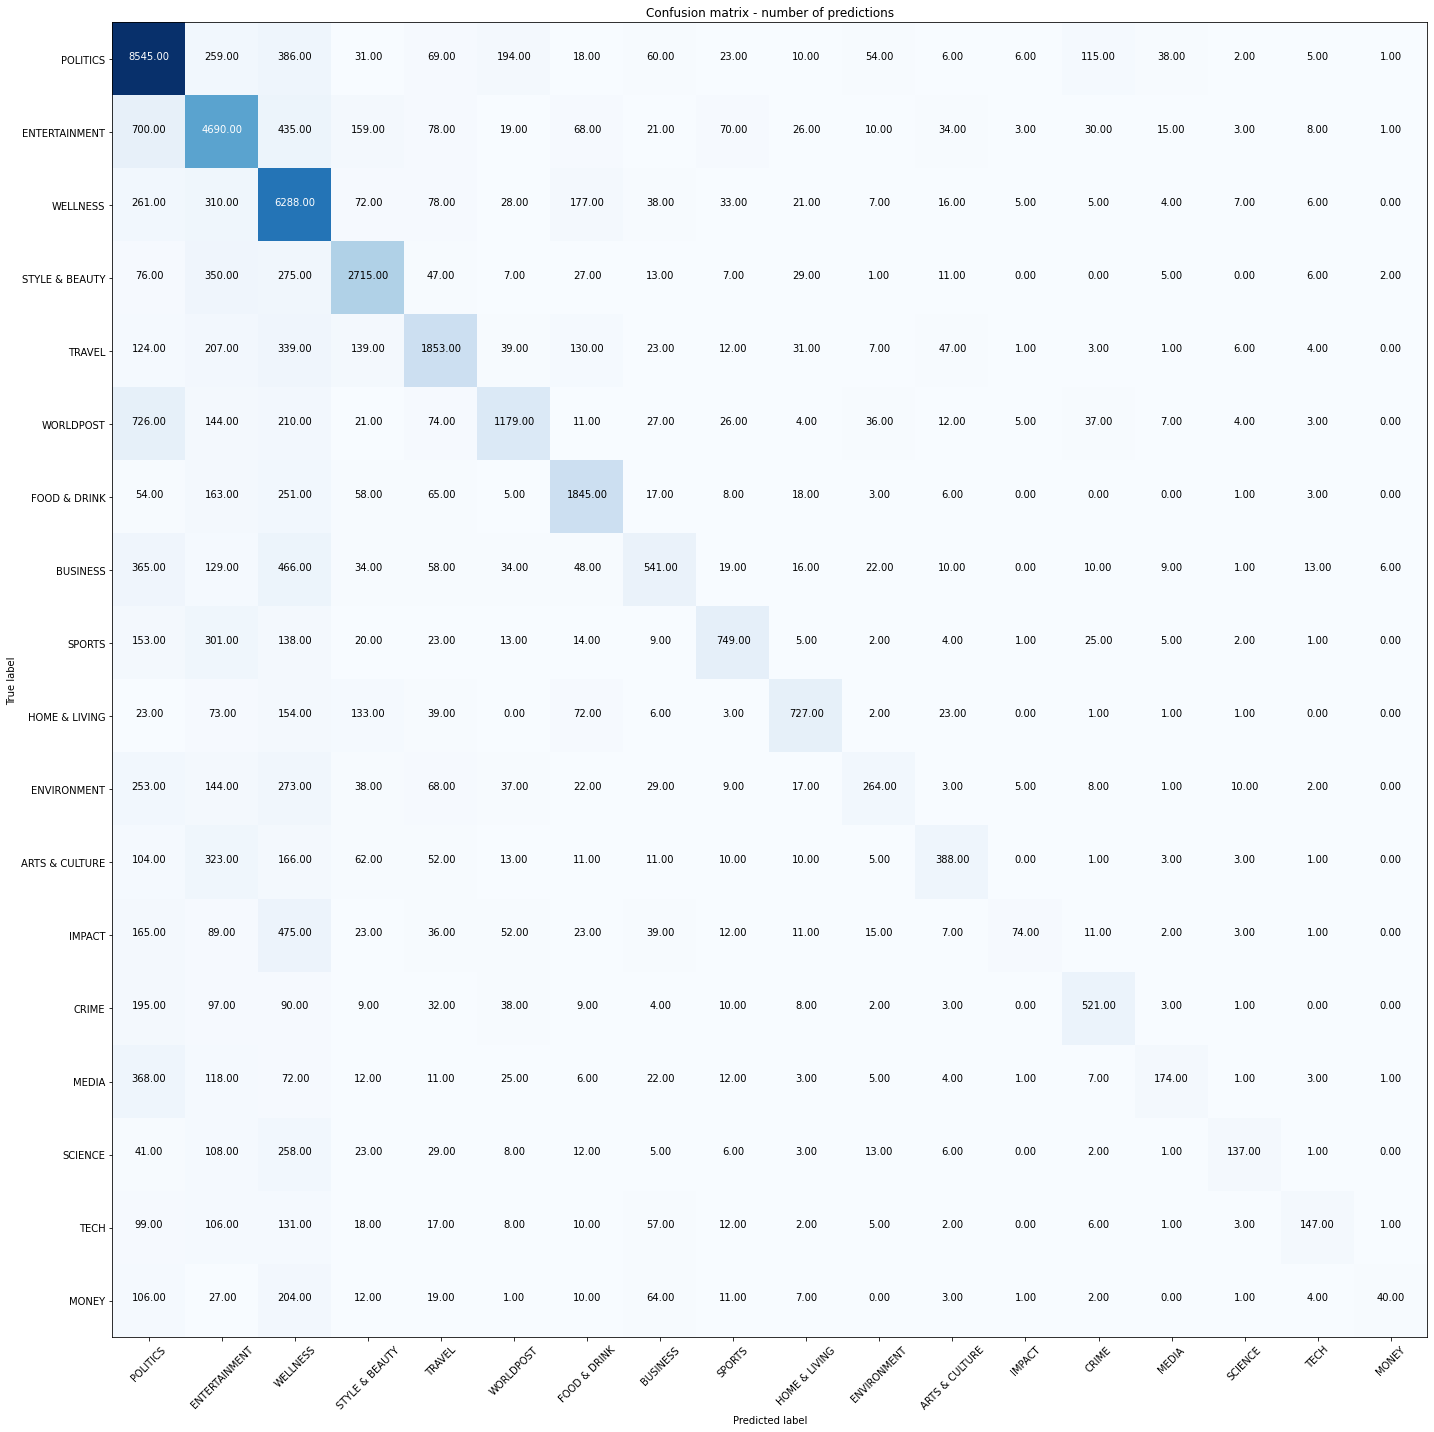

In [76]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [77]:
rfc.fit(X_train_tfidf_lemma,y_train)

RandomForestClassifier()

In [78]:
y_pred_train=rfc.predict(X_train_tfidf_lemma)
y_pred_test=rfc.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

rfc_tfidf_lemma_acc_train = accuracy_score(y_train, y_pred_train)
rfc_tfidf_lemma_acc_test =  accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9998346454522906
ACC test set: 0.6637300923841982
                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.34      0.44      1163
      BUSINESS       0.54      0.33      0.41      1781
         CRIME       0.65      0.50      0.57      1022
 ENTERTAINMENT       0.62      0.74      0.67      6370
   ENVIRONMENT       0.59      0.25      0.35      1183
  FOOD & DRINK       0.73      0.73      0.73      2497
 HOME & LIVING       0.76      0.57      0.65      1258
        IMPACT       0.68      0.07      0.12      1038
         MEDIA       0.71      0.23      0.35       845
         MONEY       0.75      0.10      0.18       512
      POLITICS       0.70      0.87      0.77      9822
       SCIENCE       0.69      0.26      0.38       653
        SPORTS       0.72      0.52      0.60      1465
STYLE & BEAUTY       0.78      0.75      0.77      3571
          TECH       0.68      0.22      0.33       625
        TRAVEL       0.70      0.64 

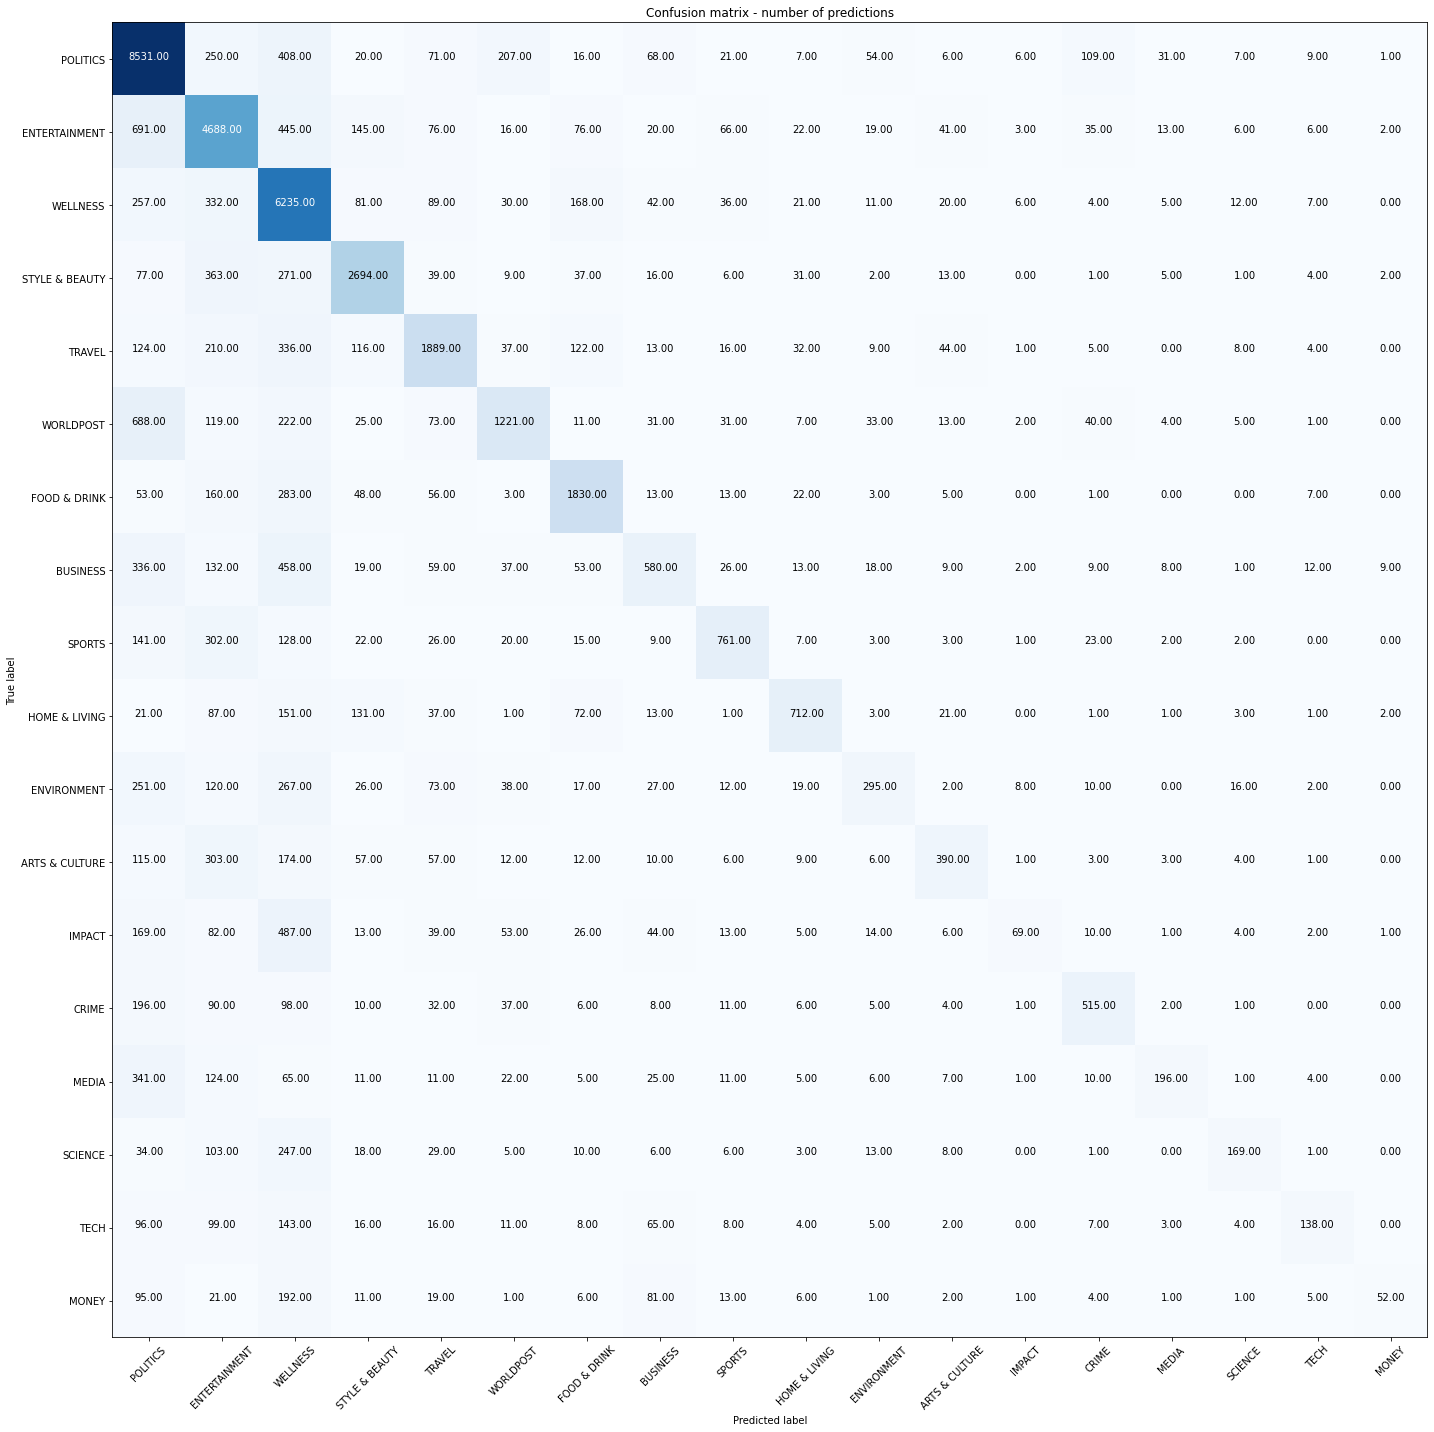

In [79]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# SGDClassifier

In [80]:
sgdc_model=SGDClassifier()

## Bag of words ngram (1,2) stemmed data

In [81]:
sgdc_model.fit(X_train_stem,y_train)

SGDClassifier()

In [82]:
y_pred_train=sgdc_model.predict(X_train_stem)
y_pred_test=sgdc_model.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

sgdc_bow_stem_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_bow_stem_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8823777983960609
ACC test set: 0.7432962510449489
                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.49      0.56      1163
      BUSINESS       0.60      0.43      0.50      1781
         CRIME       0.71      0.57      0.63      1022
 ENTERTAINMENT       0.73      0.81      0.76      6370
   ENVIRONMENT       0.61      0.47      0.53      1183
  FOOD & DRINK       0.77      0.81      0.79      2497
 HOME & LIVING       0.81      0.73      0.77      1258
        IMPACT       0.51      0.28      0.36      1038
         MEDIA       0.63      0.39      0.48       845
         MONEY       0.62      0.40      0.49       512
      POLITICS       0.77      0.87      0.82      9822
       SCIENCE       0.69      0.44      0.54       653
        SPORTS       0.75      0.76      0.75      1465
STYLE & BEAUTY       0.85      0.82      0.83      3571
          TECH       0.59      0.41      0.48       625
        TRAVEL       0.78      0.74 

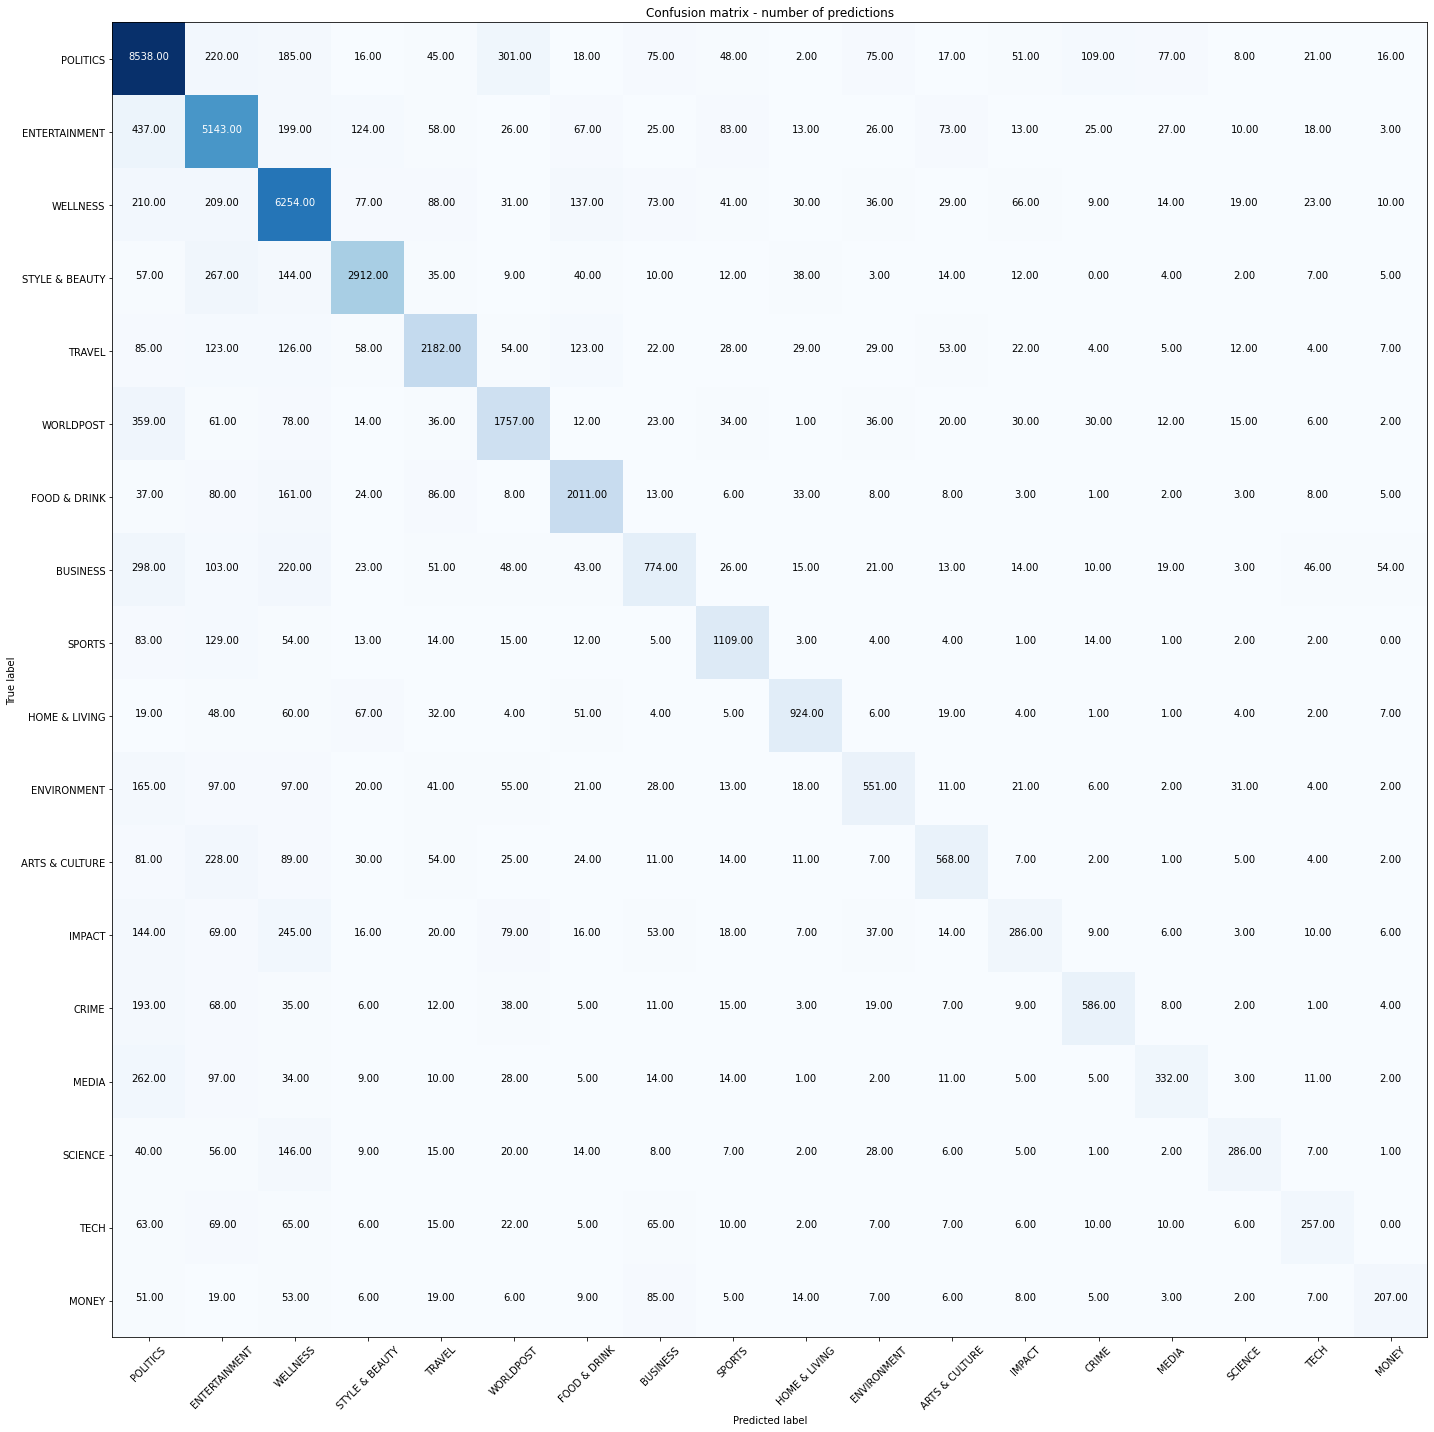

In [83]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram (1,2) lemmatized data

In [84]:
sgdc_model.fit(X_train_lemma,y_train)

SGDClassifier()

In [85]:
y_pred_train=sgdc_model.predict(X_train_lemma)
y_pred_test=sgdc_model.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

sgdc_bow_lemma_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_bow_lemma_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.8878804302892785
ACC test set: 0.7441322101472574
                precision    recall  f1-score   support

ARTS & CULTURE       0.66      0.49      0.56      1163
      BUSINESS       0.59      0.43      0.50      1781
         CRIME       0.69      0.60      0.64      1022
 ENTERTAINMENT       0.72      0.81      0.76      6370
   ENVIRONMENT       0.62      0.46      0.53      1183
  FOOD & DRINK       0.75      0.83      0.78      2497
 HOME & LIVING       0.81      0.72      0.77      1258
        IMPACT       0.50      0.25      0.33      1038
         MEDIA       0.65      0.41      0.51       845
         MONEY       0.61      0.40      0.48       512
      POLITICS       0.77      0.86      0.82      9822
       SCIENCE       0.67      0.45      0.53       653
        SPORTS       0.75      0.75      0.75      1465
STYLE & BEAUTY       0.86      0.81      0.83      3571
          TECH       0.60      0.39      0.47       625
        TRAVEL       0.78      0.74 

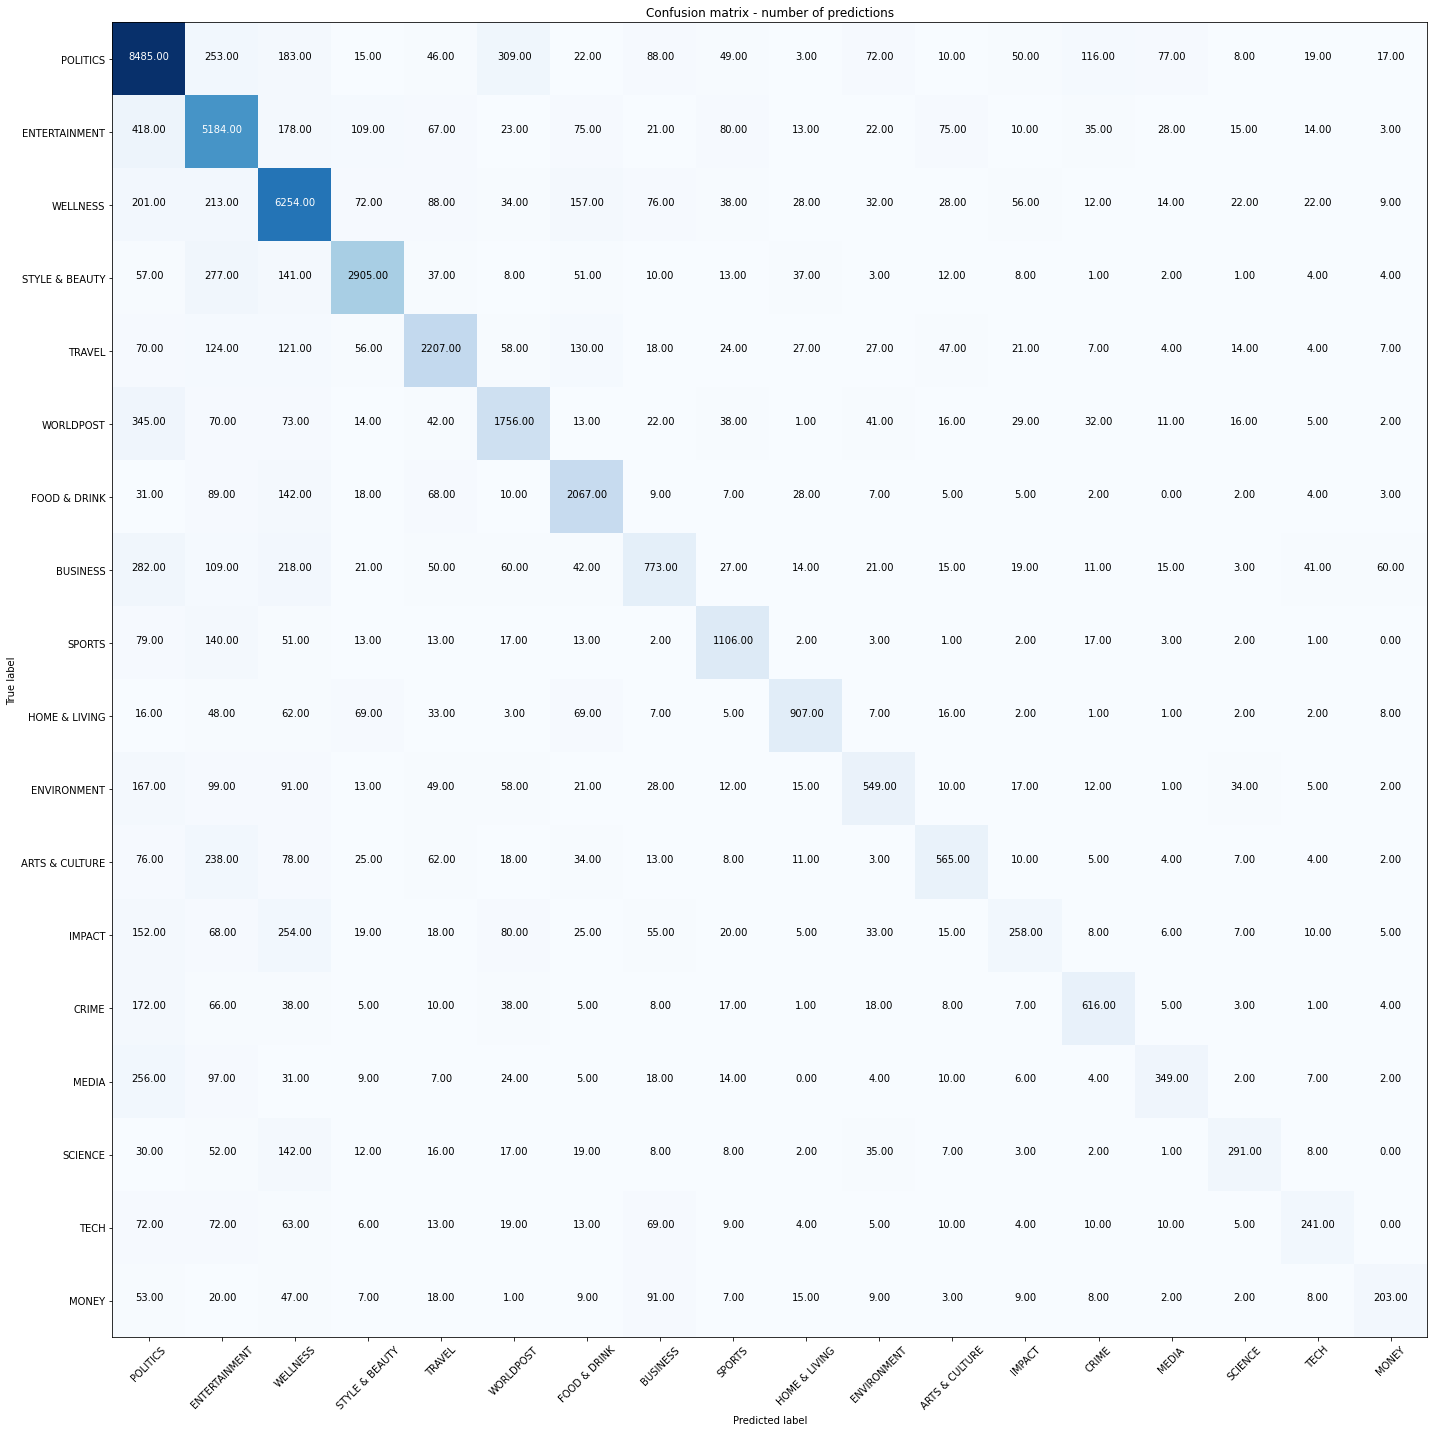

In [86]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Stemmed data

In [87]:
sgdc_model.fit(X_train_tfidf_stem,y_train)

SGDClassifier()

In [88]:
y_pred_train=sgdc_model.predict(X_train_tfidf_stem)
y_pred_test=sgdc_model.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

sgdc_tfidf_stem_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_tfidf_stem_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.7810430197414957
ACC test set: 0.7213040961996013
                precision    recall  f1-score   support

ARTS & CULTURE       0.69      0.39      0.50      1163
      BUSINESS       0.68      0.30      0.42      1781
         CRIME       0.71      0.56      0.62      1022
 ENTERTAINMENT       0.73      0.77      0.75      6370
   ENVIRONMENT       0.64      0.32      0.42      1183
  FOOD & DRINK       0.76      0.80      0.78      2497
 HOME & LIVING       0.78      0.70      0.74      1258
        IMPACT       0.61      0.13      0.22      1038
         MEDIA       0.73      0.25      0.38       845
         MONEY       0.67      0.25      0.36       512
      POLITICS       0.73      0.90      0.80      9822
       SCIENCE       0.77      0.33      0.46       653
        SPORTS       0.78      0.68      0.73      1465
STYLE & BEAUTY       0.78      0.82      0.80      3571
          TECH       0.63      0.32      0.43       625
        TRAVEL       0.72      0.76 

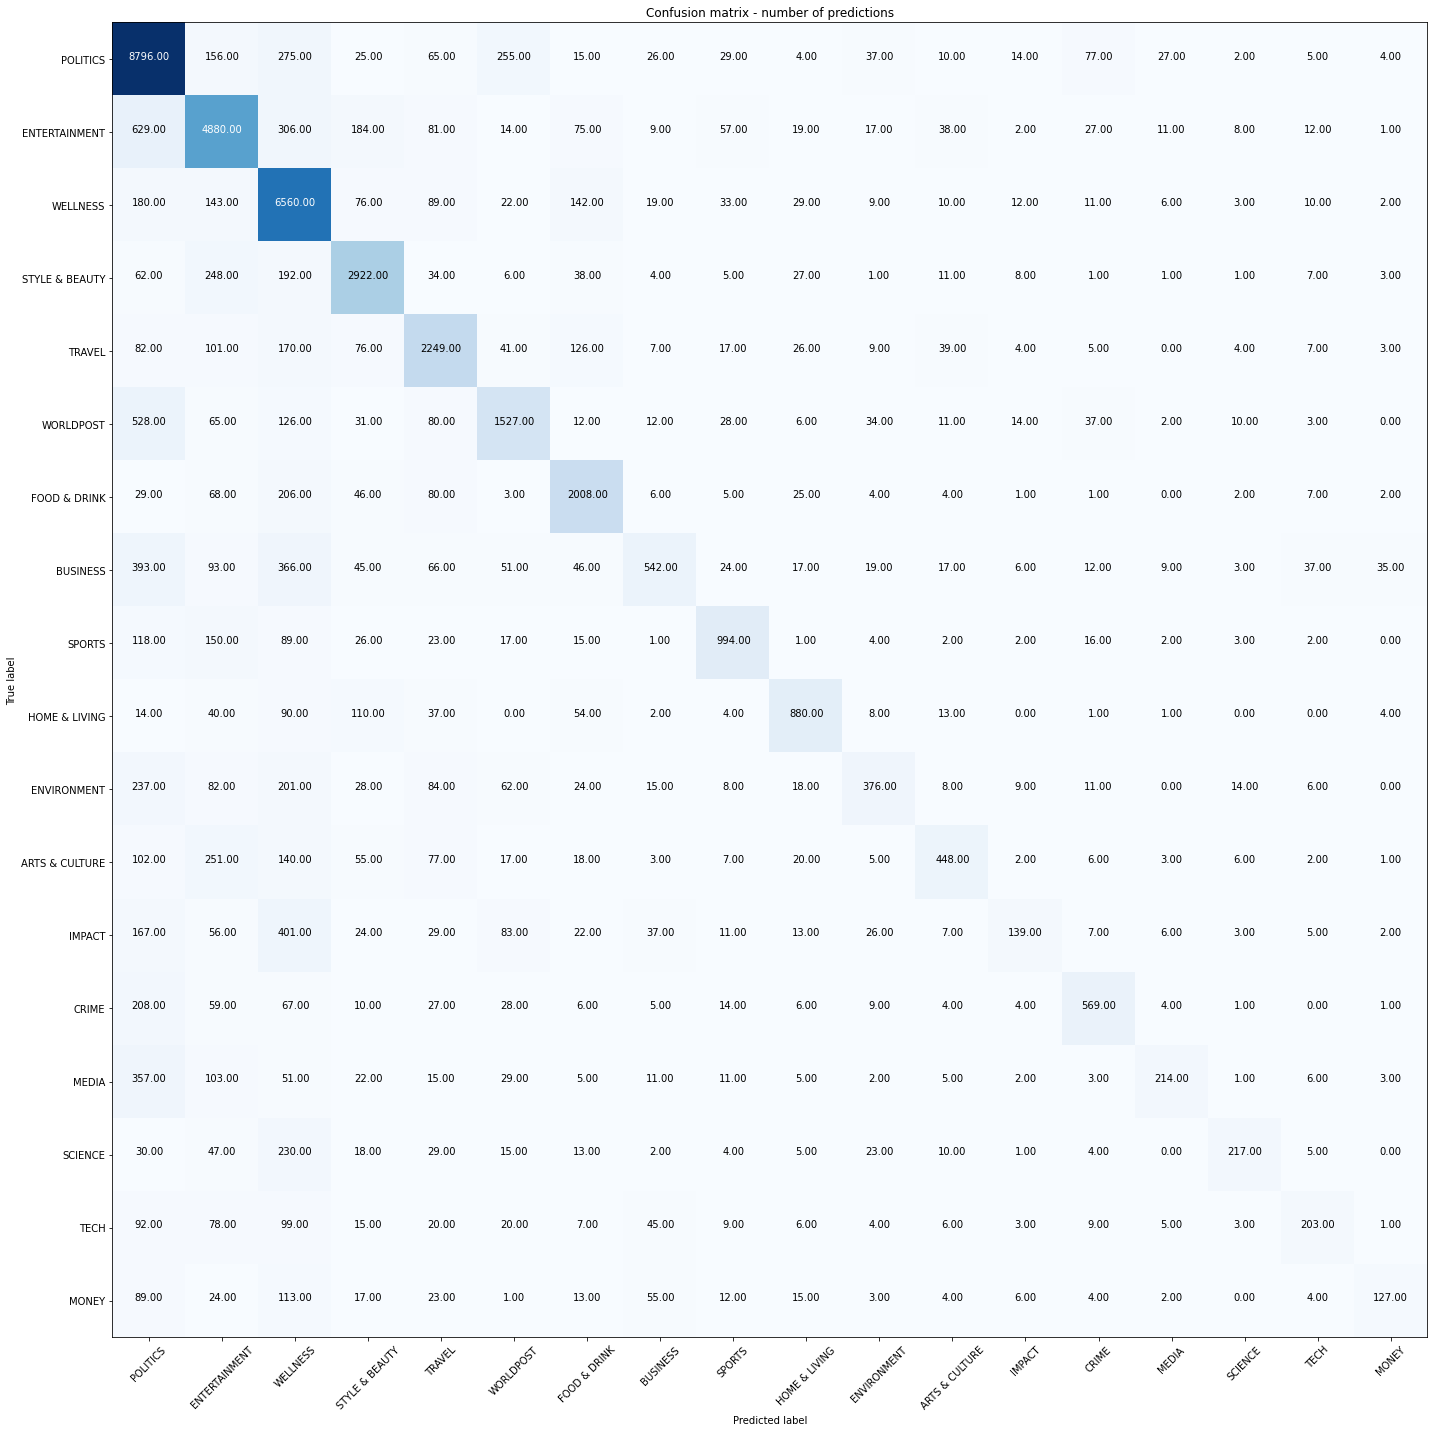

In [89]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF lemmatized data

In [90]:
sgdc_model.fit(X_train_tfidf_lemma,y_train)

SGDClassifier()

In [91]:
y_pred_train=sgdc_model.predict(X_train_tfidf_lemma)
y_pred_test=sgdc_model.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

sgdc_tfidf_lemma_train_acc = accuracy_score(y_train, y_pred_train)
sgdc_tfidf_lemma_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.7870692743691264
ACC test set: 0.723361841682207
                precision    recall  f1-score   support

ARTS & CULTURE       0.70      0.38      0.49      1163
      BUSINESS       0.67      0.32      0.43      1781
         CRIME       0.70      0.55      0.62      1022
 ENTERTAINMENT       0.73      0.77      0.75      6370
   ENVIRONMENT       0.64      0.31      0.42      1183
  FOOD & DRINK       0.78      0.80      0.79      2497
 HOME & LIVING       0.80      0.69      0.74      1258
        IMPACT       0.58      0.13      0.21      1038
         MEDIA       0.74      0.28      0.41       845
         MONEY       0.67      0.25      0.36       512
      POLITICS       0.73      0.89      0.80      9822
       SCIENCE       0.78      0.34      0.47       653
        SPORTS       0.78      0.69      0.73      1465
STYLE & BEAUTY       0.79      0.82      0.81      3571
          TECH       0.65      0.32      0.43       625
        TRAVEL       0.72      0.76  

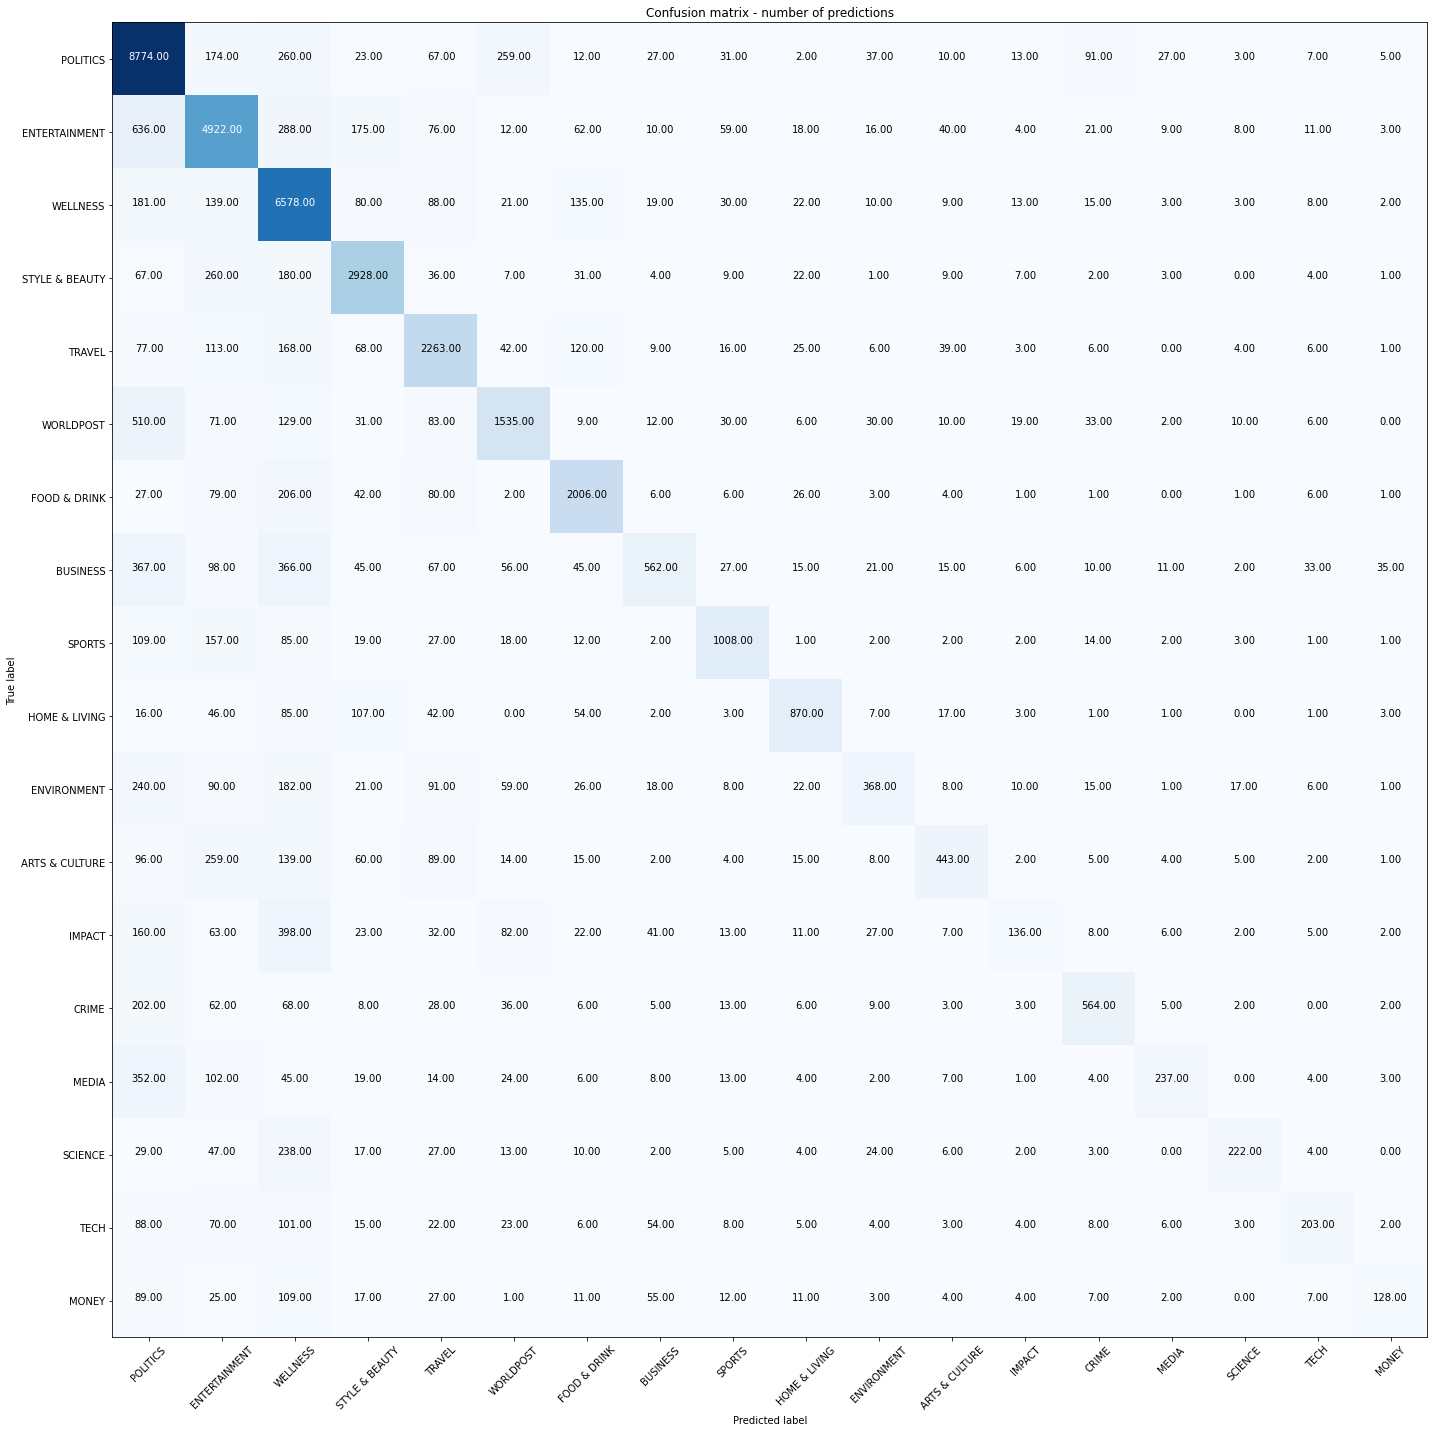

In [92]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Linear SVC

## Bag of words ngram(1,2) stemmed data

In [93]:
svm = LinearSVC()
svm.fit(X_train_stem,y_train)

LinearSVC()

In [94]:
y_pred_train=svm.predict(X_train_stem)
y_pred_test=svm.predict(X_test_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

svm_stem_train_acc = accuracy_score(y_train, y_pred_train)
svm_stem_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9965734863169112
ACC test set: 0.7038132595974536
                precision    recall  f1-score   support

ARTS & CULTURE       0.54      0.49      0.51      1163
      BUSINESS       0.47      0.44      0.45      1781
         CRIME       0.62      0.62      0.62      1022
 ENTERTAINMENT       0.71      0.76      0.74      6370
   ENVIRONMENT       0.50      0.47      0.48      1183
  FOOD & DRINK       0.75      0.75      0.75      2497
 HOME & LIVING       0.76      0.71      0.73      1258
        IMPACT       0.37      0.32      0.34      1038
         MEDIA       0.48      0.43      0.46       845
         MONEY       0.48      0.39      0.43       512
      POLITICS       0.77      0.80      0.79      9822
       SCIENCE       0.53      0.48      0.50       653
        SPORTS       0.73      0.71      0.72      1465
STYLE & BEAUTY       0.81      0.80      0.80      3571
          TECH       0.47      0.41      0.44       625
        TRAVEL       0.73      0.71 

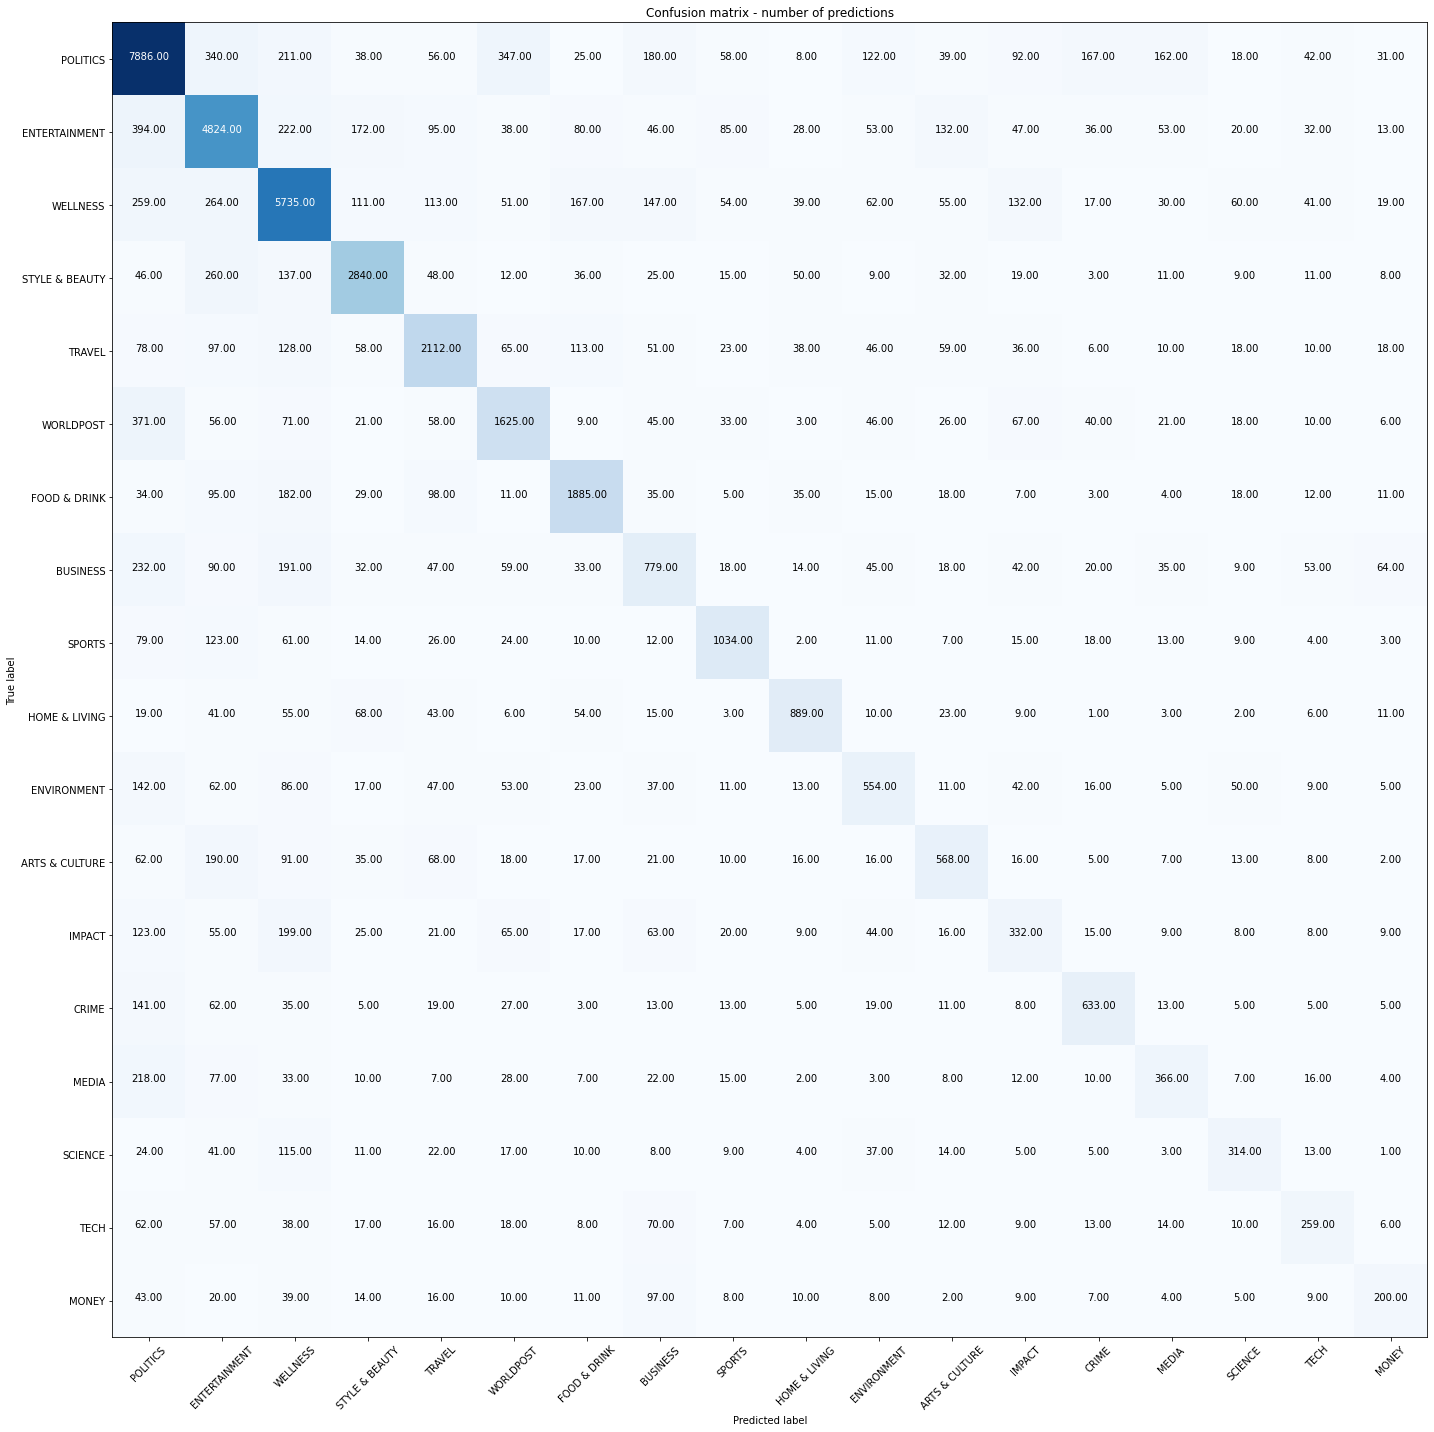

In [95]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Bag of words ngram(1,2) lemmatized data

In [96]:
svm.fit(X_train_lemma,y_train)

LinearSVC()

In [97]:
y_pred_train=svm.predict(X_train_lemma)
y_pred_test=svm.predict(X_test_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

svm_lemma_train_acc = accuracy_score(y_train, y_pred_train)
svm_lemma_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.997051177232516
ACC test set: 0.702527168670825
                precision    recall  f1-score   support

ARTS & CULTURE       0.52      0.48      0.50      1163
      BUSINESS       0.47      0.43      0.45      1781
         CRIME       0.59      0.59      0.59      1022
 ENTERTAINMENT       0.71      0.75      0.73      6370
   ENVIRONMENT       0.49      0.46      0.47      1183
  FOOD & DRINK       0.75      0.76      0.76      2497
 HOME & LIVING       0.76      0.71      0.73      1258
        IMPACT       0.36      0.31      0.33      1038
         MEDIA       0.49      0.45      0.47       845
         MONEY       0.46      0.39      0.43       512
      POLITICS       0.77      0.80      0.79      9822
       SCIENCE       0.53      0.47      0.50       653
        SPORTS       0.73      0.72      0.73      1465
STYLE & BEAUTY       0.81      0.80      0.80      3571
          TECH       0.49      0.44      0.46       625
        TRAVEL       0.73      0.71   

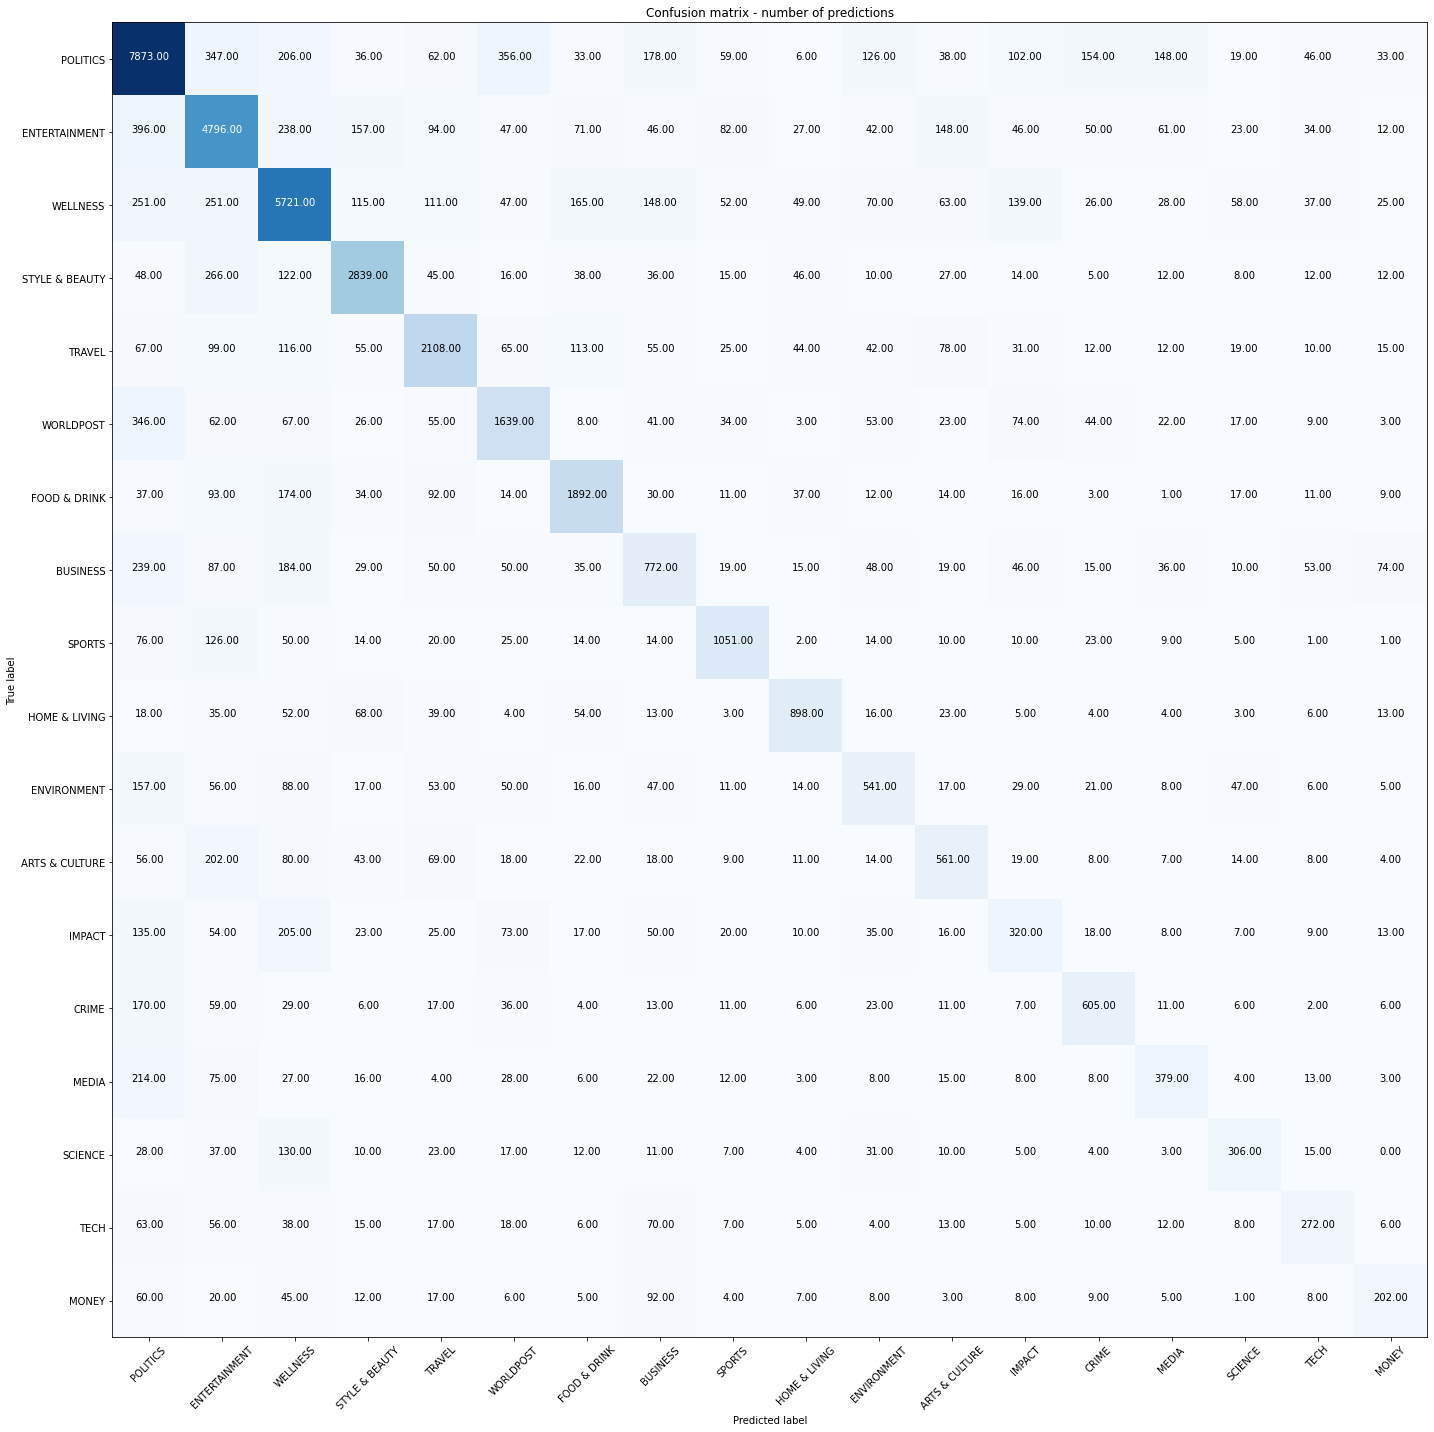

In [98]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Stemmed data

In [99]:
svm.fit(X_train_tfidf_stem,y_train)

LinearSVC()

In [100]:
y_pred_train=svm.predict(X_train_tfidf_stem)
y_pred_test=svm.predict(X_test_tfidf_stem)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

svm_tfidf_stem_train_acc = accuracy_score(y_train, y_pred_train)
svm_tfidf_stem_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9640170131456866
ACC test set: 0.7503268814438514
                precision    recall  f1-score   support

ARTS & CULTURE       0.63      0.52      0.57      1163
      BUSINESS       0.57      0.46      0.51      1781
         CRIME       0.69      0.65      0.67      1022
 ENTERTAINMENT       0.76      0.80      0.78      6370
   ENVIRONMENT       0.60      0.53      0.56      1183
  FOOD & DRINK       0.79      0.81      0.80      2497
 HOME & LIVING       0.80      0.75      0.77      1258
        IMPACT       0.48      0.32      0.38      1038
         MEDIA       0.63      0.46      0.53       845
         MONEY       0.58      0.42      0.49       512
      POLITICS       0.79      0.85      0.82      9822
       SCIENCE       0.66      0.48      0.56       653
        SPORTS       0.79      0.75      0.77      1465
STYLE & BEAUTY       0.84      0.83      0.84      3571
          TECH       0.57      0.45      0.50       625
        TRAVEL       0.76      0.78 

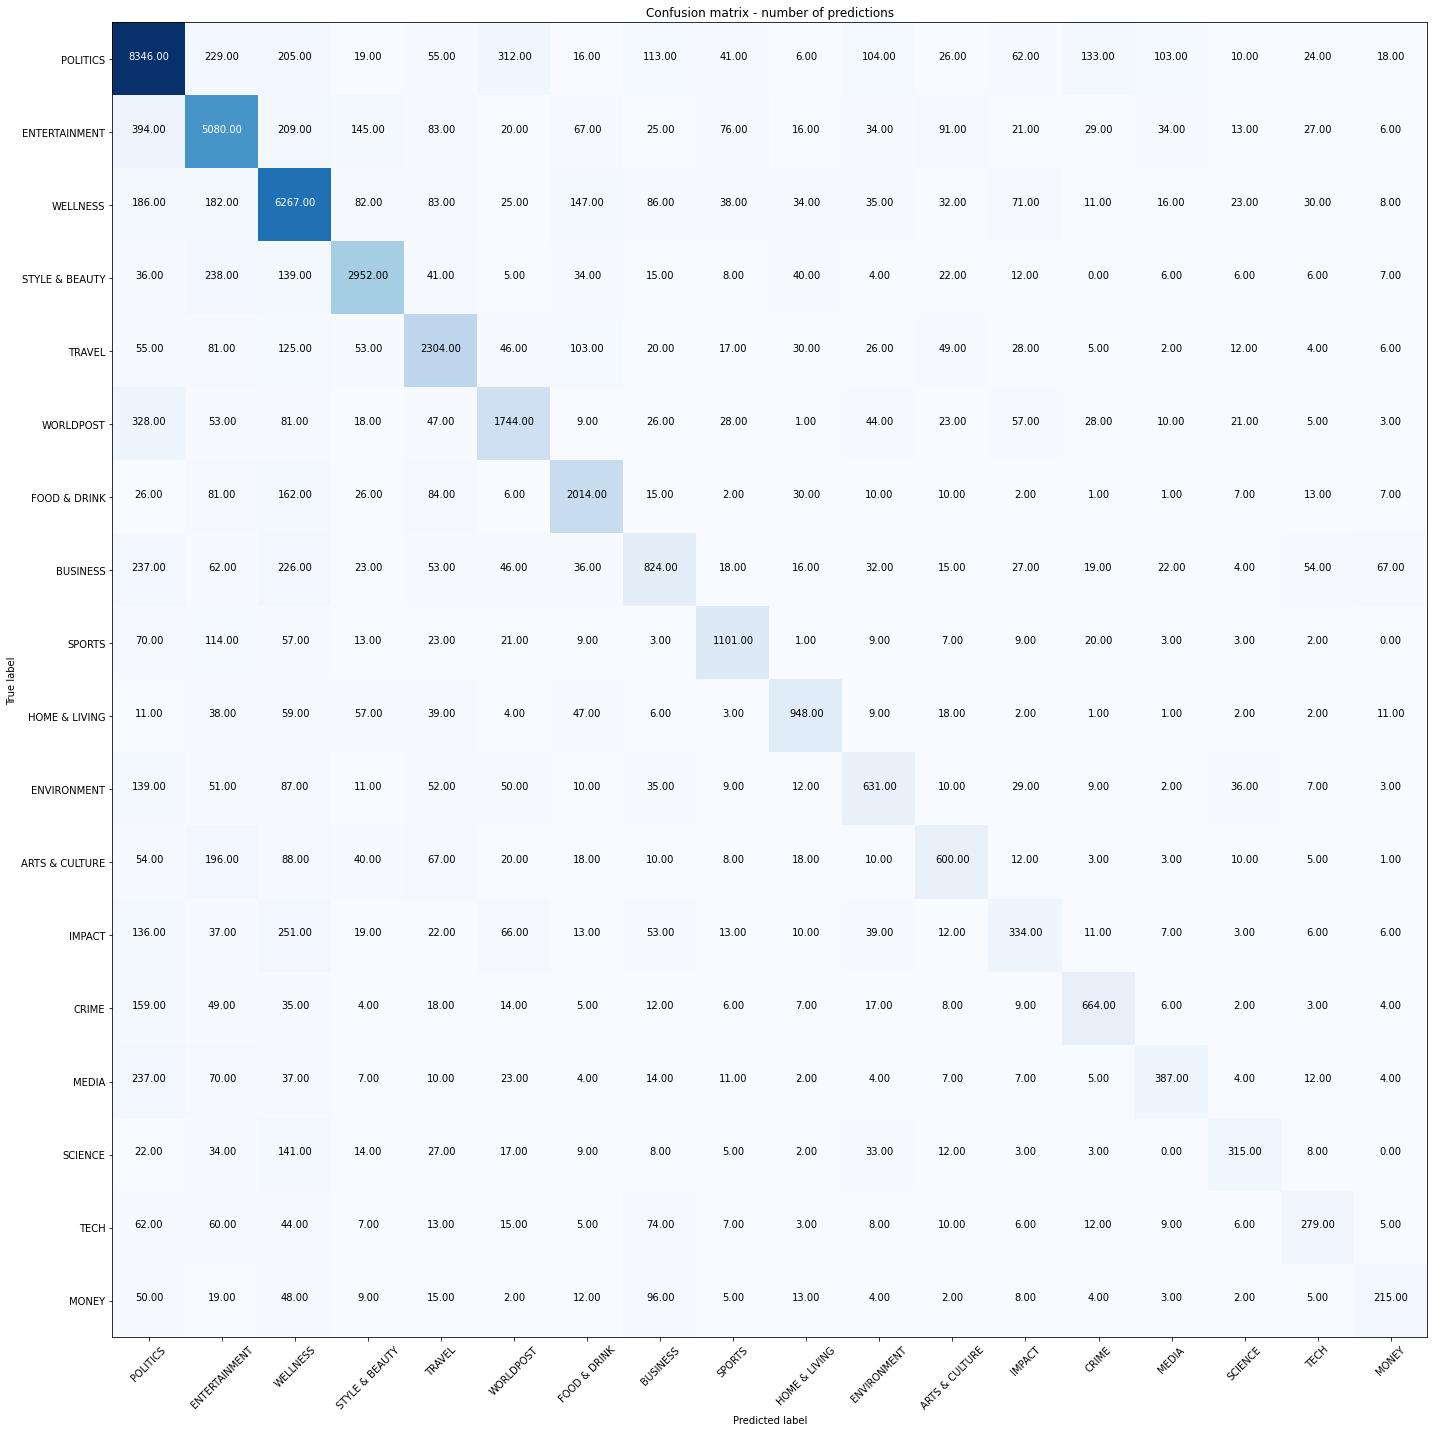

In [101]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## TFIDF Lemmatized data

In [102]:
svm.fit(X_train_tfidf_lemma,y_train)

LinearSVC()

In [103]:
y_pred_train=svm.predict(X_train_tfidf_lemma)
y_pred_test=svm.predict(X_test_tfidf_lemma)

print('ACC train set: {}'.format(accuracy_score(y_train, y_pred_train)))
print('ACC test set: {}'.format(accuracy_score(y_test, y_pred_test)))

svm_tfidf_lemma_train_acc = accuracy_score(y_train, y_pred_train)
svm_tfidf_lemma_test_acc = accuracy_score(y_test, y_pred_test)

print(classification_report(y_test, y_pred_test))

ACC train set: 0.9675078313751068
ACC test set: 0.7505840996291772
                precision    recall  f1-score   support

ARTS & CULTURE       0.62      0.52      0.56      1163
      BUSINESS       0.56      0.47      0.51      1781
         CRIME       0.69      0.65      0.67      1022
 ENTERTAINMENT       0.76      0.80      0.78      6370
   ENVIRONMENT       0.59      0.52      0.55      1183
  FOOD & DRINK       0.79      0.81      0.80      2497
 HOME & LIVING       0.80      0.75      0.78      1258
        IMPACT       0.49      0.32      0.39      1038
         MEDIA       0.63      0.47      0.54       845
         MONEY       0.56      0.42      0.48       512
      POLITICS       0.79      0.85      0.82      9822
       SCIENCE       0.65      0.48      0.55       653
        SPORTS       0.79      0.75      0.77      1465
STYLE & BEAUTY       0.84      0.83      0.84      3571
          TECH       0.59      0.45      0.51       625
        TRAVEL       0.76      0.77 

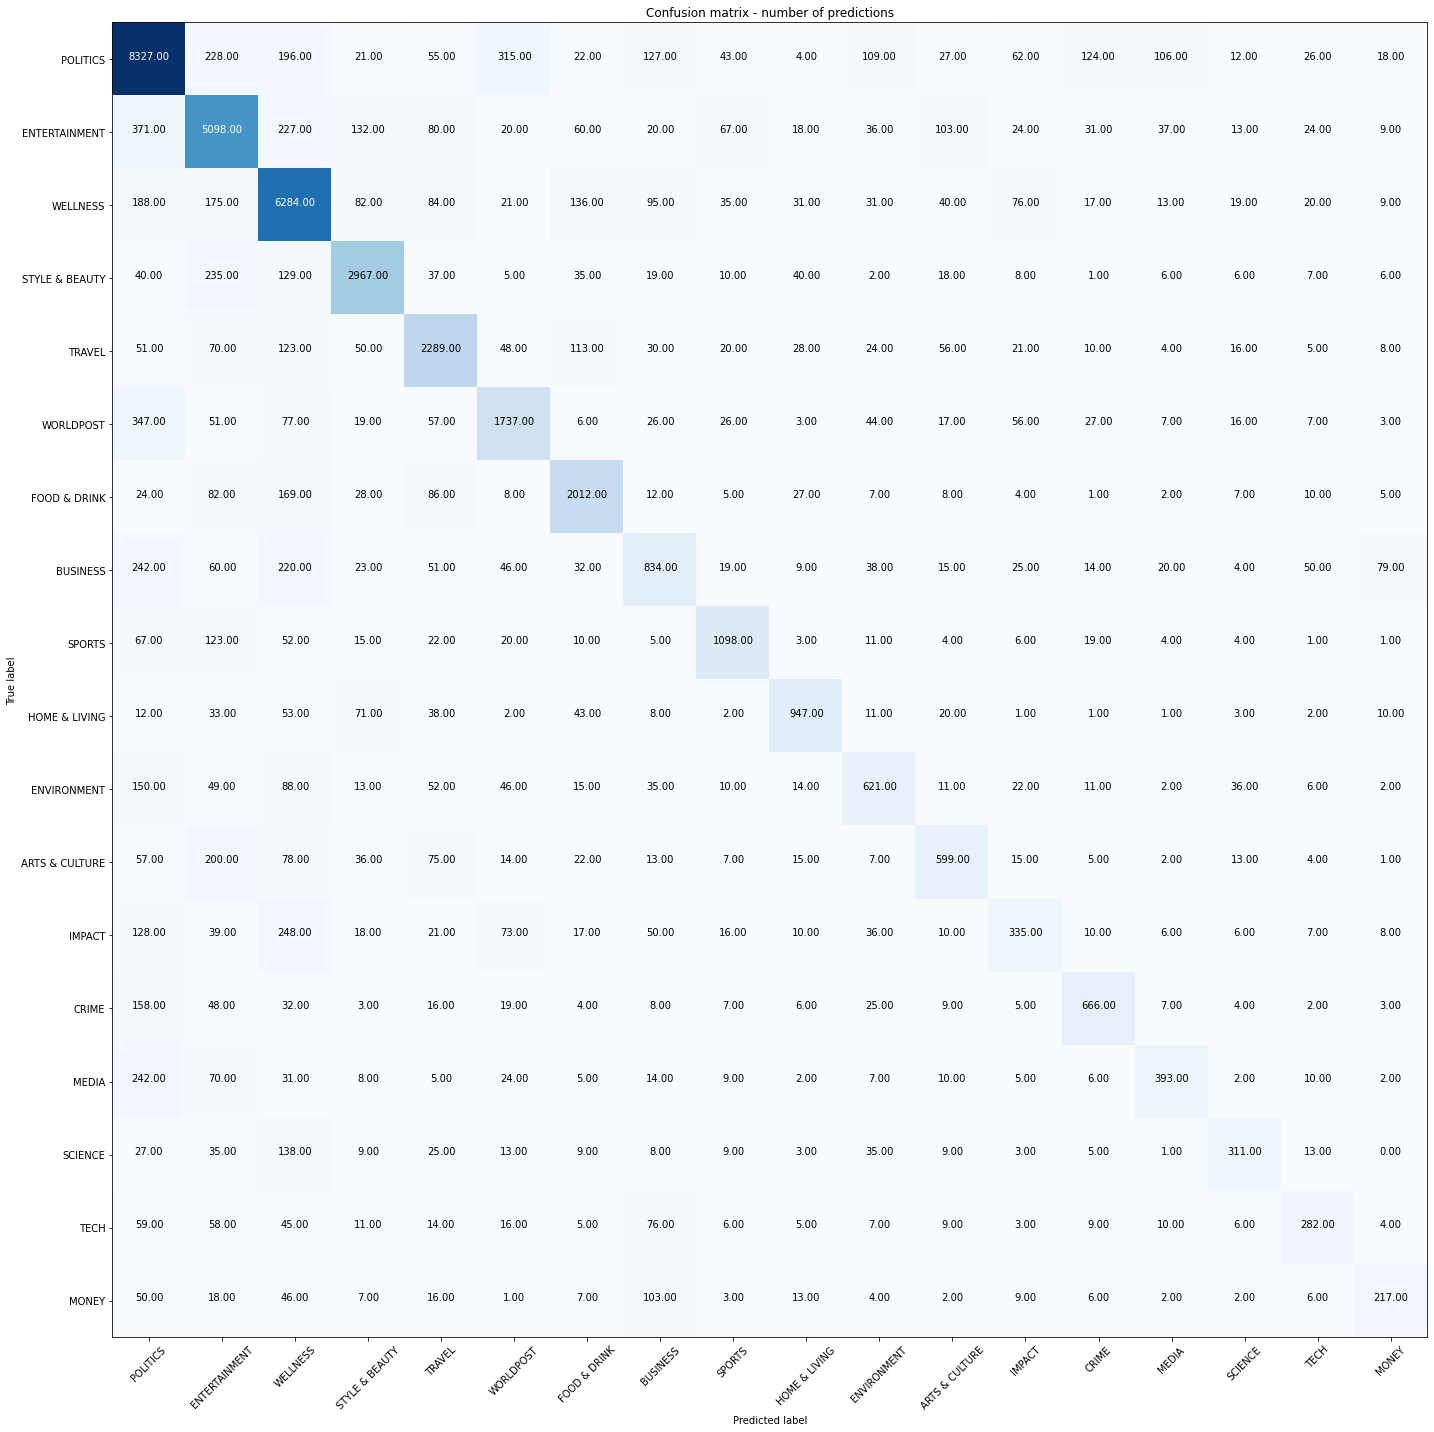

In [104]:
labels=['POLITICS','ENTERTAINMENT','WELLNESS','STYLE & BEAUTY','TRAVEL','WORLDPOST','FOOD & DRINK', 'BUSINESS','SPORTS', 'HOME & LIVING', 'ENVIRONMENT','ARTS & CULTURE','IMPACT','CRIME','MEDIA','SCIENCE','TECH','MONEY']

cm = confusion_matrix(y_test, y_pred_test, labels=labels)

cmap=plt.cm.Blues
plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix - number of predictions')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Results



In [105]:
print('MultinomialNB BOW ngram (1,2) accuracy stemm data')
print(f'dla train {nb_bow_stem_train_acc}')
print(f'dla test  {nb_bow_stem_test_acc}')
print('-'*50)

print('MultinomialNB BOW ngram (1,2) accuracy lemmatized data')
print(f'dla train {nb_lemma_train_accuracy}')
print(f'dla test  {nb_lemma_test_accuracy}')
print('-'*50)

print('MultinomialNB Tfidf ngram (1,2) accuracy on stemmed data')
print(f'dla train {nb_tfidf_stem_train}')
print(f'dla test  {nb_tfidf_stem_test}')
print('-'*50)

print('MultinomialNB Tfidf ngram (1,2)accuracy on lemmatized data')
print(f'dla train {nb_tfidf_lemma_train}')
print(f'dla test  {nb_tfidf_lemma_test}')
print('-'*50)

print('Logistic Regression BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {log_reg_bow_stemm_acc_train}')
print(f'dla test  {log_reg_bow_stemm_acc_test}')
print('-'*50)

print('Logistic Regression BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {log_reg_bow_lemma_acc_train}')
print(f'dla test  {log_reg_bow_lemma_acc_test}')
print('-'*50)

print('Logistic Regression TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {log_reg_tfidf_stemm_acc_train}')
print(f'dla test  {log_reg_tfidf_stemm_acc_test}')
print('-'*50)

print('Logistic Regression TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {log_reg_tfidf_lemma_acc_train}')
print(f'dla test  {log_reg_tfidf_lemma_acc_test}')
print('-'*50)

print('Random Forest Classifier BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {rfc_stem_acc_train}')
print(f'dla test  {rfc_stem_acc_test}')
print('-'*50)

print('Random Forest Classifier BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {rfc_lemma_acc_train}')
print(f'dla test  {rfc_lemma_acc_test}')
print('-'*50)


print('Random Forest Classifier TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {rfc_tfidf_stem_acc_train}')
print(f'dla test  {rfc_tfidf_stem_acc_test}')
print('-'*50)

print('Random Forest Classifier TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {rfc_tfidf_stem_acc_train}')
print(f'dla test  {rfc_tfidf_stem_acc_test}')
print('-'*50)

rfc_tfidf_stem_acc_train
print('SGDClassifier BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {sgdc_bow_stem_train_acc}')
print(f'dla test  {sgdc_bow_stem_test_acc}')
print('-'*50)

print('SGDClassifier BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {sgdc_bow_lemma_train_acc}')
print(f'dla test  {sgdc_bow_lemma_test_acc}')
print('-'*50)

print('SGDClassifier TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {sgdc_tfidf_stem_train_acc}')
print(f'dla test  {sgdc_tfidf_stem_test_acc}')
print('-'*50)

print('SGDClassifier TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {sgdc_tfidf_lemma_train_acc}')
print(f'dla test  {sgdc_tfidf_lemma_test_acc}')
print('-'*50)

print('SVM BOW ngram(1,2) accuracy on stemmed data')
print(f'dla train {svm_stem_train_acc}')
print(f'dla test  {svm_stem_test_acc}')
print('-'*50)

print('SVM BOW ngram(1,2) accuracy on lemmatized data')
print(f'dla train {svm_lemma_train_acc}')
print(f'dla test  {svm_lemma_test_acc}')
print('-'*50)

print('SVM TFIDF ngram(1,2) accuracy on stemmed data')
print(f'dla train {svm_tfidf_stem_train_acc}')
print(f'dla test  {svm_tfidf_stem_test_acc}')
print('-'*50)

print('SVM TFIDF ngram(1,2) accuracy on lemmatized data')
print(f'dla train {svm_tfidf_lemma_train_acc}')
print(f'dla test  {svm_tfidf_lemma_test_acc}')
print('-'*50)

MultinomialNB BOW ngram (1,2) accuracy stemm data
dla train 0.8097963383154047
dla test  0.732750305446595
--------------------------------------------------
MultinomialNB BOW ngram (1,2) accuracy lemmatized data
dla train 0.8155010702113782
dla test  0.7347651812316464
--------------------------------------------------
MultinomialNB Tfidf ngram (1,2) accuracy on stemmed data
dla train 0.6700717455009784
dla test  0.6261762373266456
--------------------------------------------------
MultinomialNB Tfidf ngram (1,2)accuracy on lemmatized data
dla train 0.6785140137979184
dla test  0.6317921677062568
--------------------------------------------------
Logistic Regression BOW ngram(1,2) accuracy on stemmed data
dla train 0.9704382814150675
dla test  0.7358797933680578
--------------------------------------------------
Logistic Regression BOW ngram(1,2) accuracy on lemmatized data
dla train 0.9736443223678771
dla test  0.7368443615630291
--------------------------------------------------
Log

# GridSearch

In [106]:
# z powyższych danych wynika, że najlepsze rezultaty zostały osiągniete dla danych po procesie lemmatyzacji:
# Logistic Regression TFIDF ngram(1,2) lemmatized data
# SGDClassifier BOW ngram(1,2) lemmatized data
# SVM TFIDF ngram(1,2) lemmatized data

#przystepuje do optymalizacji parametrów

In [107]:
print('GridSearch Logistic Regression BOW ngram(1,2) accuracy on lemmatized data' )

vectorizer = TfidfVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

X_train = vectorizer.fit_transform(train_data['lemma'])
X_test = vectorizer.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category

GridSearch Logistic Regression BOW ngram(1,2) accuracy on lemmatized data


In [108]:
model = LogisticRegression()

params={
    'C':[0.01,0.1,1,10,100],
    'multi_class':['multinomial']
}

In [109]:
grid_search_lr = GridSearchCV(model, param_grid=params, cv=5)

In [110]:
grid_search_lr.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['multinomial']})

In [111]:
y_pred_lr=grid_search_lr.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr))



                precision    recall  f1-score   support

ARTS & CULTURE       0.62      0.53      0.58      1163
      BUSINESS       0.54      0.51      0.53      1781
         CRIME       0.69      0.65      0.67      1022
 ENTERTAINMENT       0.76      0.79      0.78      6370
   ENVIRONMENT       0.58      0.54      0.56      1183
  FOOD & DRINK       0.80      0.79      0.79      2497
 HOME & LIVING       0.81      0.75      0.78      1258
        IMPACT       0.48      0.35      0.40      1038
         MEDIA       0.66      0.45      0.53       845
         MONEY       0.76      0.23      0.35       512
      POLITICS       0.78      0.85      0.81      9822
       SCIENCE       0.61      0.53      0.57       653
        SPORTS       0.81      0.72      0.76      1465
STYLE & BEAUTY       0.85      0.82      0.84      3571
          TECH       0.60      0.44      0.51       625
        TRAVEL       0.76      0.78      0.77      2966
      WELLNESS       0.76      0.85      0.80  

In [112]:
print('grid search best params', grid_search_lr.best_params_)
print('accuracy', grid_search_lr.best_score_)

                              

grid search best params {'C': 10, 'multi_class': 'multinomial'}
accuracy 0.7430114521191484


In [113]:


print('GridSearch SGDClassifier BOW ngram(1,2) accuracy on lemmatized data' )

vectorizer = CountVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

X_train = vectorizer.fit_transform(train_data['lemma'])
X_test = vectorizer.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category


sgdc_model=SGDClassifier()

params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1]
}
    

GridSearch SGDClassifier BOW ngram(1,2) accuracy on lemmatized data


In [114]:
grid_search_sgdc = GridSearchCV(sgdc_model, param_grid=params, cv=5)

In [115]:
grid_search_sgdc.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

GridSearchCV(cv=5, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber', 'perceptron']})

In [120]:
y_pred_sgdc=grid_search_sgdc.predict(X_test)

print(classification_report(y_test, y_pred_sgdc))

                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.49      0.56      1163
      BUSINESS       0.59      0.43      0.50      1781
         CRIME       0.69      0.59      0.64      1022
 ENTERTAINMENT       0.73      0.81      0.76      6370
   ENVIRONMENT       0.63      0.47      0.54      1183
  FOOD & DRINK       0.76      0.82      0.79      2497
 HOME & LIVING       0.82      0.73      0.77      1258
        IMPACT       0.52      0.26      0.35      1038
         MEDIA       0.66      0.42      0.51       845
         MONEY       0.60      0.39      0.48       512
      POLITICS       0.77      0.86      0.82      9822
       SCIENCE       0.68      0.44      0.53       653
        SPORTS       0.75      0.75      0.75      1465
STYLE & BEAUTY       0.85      0.82      0.83      3571
          TECH       0.60      0.39      0.47       625
        TRAVEL       0.76      0.76      0.76      2966
      WELLNESS       0.76      0.86      0.80  

In [121]:
print('grid search best params', grid_search_sgdc.best_params_)
print('accuracy', grid_search_sgdc.best_score_)

grid search best params {'alpha': 0.0001, 'loss': 'hinge'}
accuracy 0.737747696820426


In [124]:
print('GridSearch LinearSVC TFIDF on lemmatized data' )

vectorizer = TfidfVectorizer(min_df=5, max_df=0.3, ngram_range=(1,2))

X_train = vectorizer.fit_transform(train_data['lemma'])
X_test = vectorizer.transform(test_data['lemma'])

y_train = train_data.category
y_test= test_data.category


svm_model=LinearSVC()

params = {
    "loss" : ["hinge","squared_hinge"],
    "C" : [ 0.001, 0.01, 0.1, 1, 10],
    'multi_class': ['ovr','crammer_singer']
}

grid_search_svm = GridSearchCV(svm_model, param_grid=params, cv=5)



GridSearch LinearSVC TFIDF on lemmatized data


In [125]:
grid_search_svm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr', 'crammer_singer']})

In [126]:
y_pred_svm=grid_search_svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

                precision    recall  f1-score   support

ARTS & CULTURE       0.66      0.52      0.58      1163
      BUSINESS       0.61      0.45      0.52      1781
         CRIME       0.68      0.67      0.67      1022
 ENTERTAINMENT       0.78      0.80      0.79      6370
   ENVIRONMENT       0.60      0.51      0.56      1183
  FOOD & DRINK       0.79      0.82      0.80      2497
 HOME & LIVING       0.79      0.77      0.78      1258
        IMPACT       0.52      0.28      0.36      1038
         MEDIA       0.65      0.46      0.54       845
         MONEY       0.58      0.43      0.50       512
      POLITICS       0.80      0.86      0.83      9822
       SCIENCE       0.67      0.48      0.56       653
        SPORTS       0.77      0.78      0.77      1465
STYLE & BEAUTY       0.84      0.84      0.84      3571
          TECH       0.60      0.45      0.51       625
        TRAVEL       0.75      0.79      0.77      2966
      WELLNESS       0.77      0.87      0.81  

In [127]:
print('grid search best params', grid_search_svm.best_params_)
print('accuracy', grid_search_svm.best_score_)

grid search best params {'C': 1, 'loss': 'hinge', 'multi_class': 'ovr'}
accuracy 0.7527857434196397


In [129]:
from sklearn import metrics 

models = []

models.append(('Logistic regression', grid_search_lr))
models.append(('SGDClassifier', grid_search_sgdc))
models.append(('LinearSVC', grid_search_svm))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []

for name, model in models:
  print(name)
  print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test), average= 'weighted') ))
  print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test))))
  precision_score.append(metrics.precision_score(y_test, model.predict(X_test) , average= 'weighted'))
  recall_score.append(metrics.recall_score(y_test, model.predict(X_test), average= 'weighted'))
  f1_score.append( metrics.f1_score(y_test, model.predict(X_test), average= 'weighted'))
  accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    



Logistic regression
precision_score: 0.7438923455009647
recall_score: 0.7483977450539087
f1_score: 0.7427492369377199
accuracy_score: 0.7483977450539087
SGDClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_score: 0.658626167739742
recall_score: 0.5440164619638609
f1_score: 0.4817576441061443
accuracy_score: 0.5440164619638609


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearSVC
precision_score: 0.7503361942595107
recall_score: 0.7583220800377254
f1_score: 0.7511393873971011
accuracy_score: 0.7583220800377254


In [136]:
results = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(results, index= models)

In [137]:
df

precision_score  ...  accuracy_score
(Logistic regression, GridSearchCV(cv=5, estimator=LogisticRegression(),\n             param_grid={'C': [0.01, 0.1, 1, 10, 100],\n                         'multi_class': ['multinomial']}))                                                                                   0.743892  ...        0.748398
(SGDClassifier, GridSearchCV(cv=5, estimator=SGDClassifier(),\n             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],\n                         'loss': ['hinge', 'log', 'squared_hinge',\n                                  'modified_huber', 'perceptron']}))         0.658626  ...        0.544016
(LinearSVC, GridSearchCV(cv=5, estimator=LinearSVC(),\n             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],\n                         'loss': ['hinge', 'squared_hinge'],\n                         'multi_class': ['ovr', 'crammer_singer']}))                            0.750336  ...        0.758322

[3 rows x 4 columns]